In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm    # 한글폰트

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
# 맥
rcParams['font.family'] = 'AppleGothic'


# 마이너스 깨짐 방지
rcParams['axes.unicode_minus'] = False


# 데이터 불러오기

In [3]:
ad_hourly_df = pd.read_csv("목록+시간대_0915_1236.csv" , encoding="utf-8-sig", parse_dates=["rpt_time_date"])


In [4]:
ad_hourly_df.shape

(7133882, 13)

### 7-8월 데이터 상위/하위조합

In [5]:
cvr_top_78_df = pd.read_csv("converted_margin_top.csv" , encoding="utf-8-sig")
cvr_bottom_78_df = pd.read_csv("converted_cvr_bottom.csv" , encoding="utf-8-sig")
margin__top_78_df = pd.read_csv("converted_cvr_top.csv" , encoding="utf-8-sig")
margin__bottom_78_df = pd.read_csv("converted_margin_bottom.csv" , encoding="utf-8-sig")


### mda_ads 칼럼 삭제

In [6]:
ad_hourly_df = ad_hourly_df.drop(columns=['mda_ads'])

### info()

In [7]:
ad_hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7133882 entries, 0 to 7133881
Data columns (total 12 columns):
 #   Column          Dtype         
---  ------          -----         
 0   rpt_time_date   datetime64[ns]
 1   rpt_time_time   float64       
 2   ads_idx         int64         
 3   mda_idx         float64       
 4   rpt_time_clk    float64       
 5   rpt_time_turn   float64       
 6   rpt_time_acost  float64       
 7   rpt_time_cost   float64       
 8   rpt_time_earn   float64       
 9   ads_type        float64       
 10  ads_category    float64       
 11  ads_name        object        
dtypes: datetime64[ns](1), float64(9), int64(1), object(1)
memory usage: 653.1+ MB


In [8]:
# merged_df.to_csv("목록+시간대_0915_1236.csv", index=False, encoding="utf-8-sig")

# 데이터 전처리

### null 값 확인

In [9]:
ad_hourly_df.isnull().sum()

rpt_time_date     212867
rpt_time_time     212867
ads_idx                0
mda_idx           212867
rpt_time_clk      212867
rpt_time_turn     212867
rpt_time_acost    212867
rpt_time_cost     212867
rpt_time_earn     212867
ads_type            5248
ads_category        5248
ads_name            5248
dtype: int64

### null 값 삭제

In [10]:
ad_hourly_df = ad_hourly_df.dropna()

In [11]:
ad_hourly_df.shape

(6915767, 12)

### 클릭수, 전환수 모두 0인 항목 삭제

In [12]:
# 클릭수와 전환수가 모두 0인 행 제거
ad_hourly_df = ad_hourly_df[~((ad_hourly_df["rpt_time_clk"] == 0) & (ad_hourly_df["rpt_time_turn"] == 0))]

### 클릭수 < 전환수 항목 삭제

In [13]:
ad_hourly_df = ad_hourly_df[ad_hourly_df["rpt_time_clk"] >= ad_hourly_df["rpt_time_turn"]].copy()

### acost == 0인 항목 삭제

In [14]:
ad_hourly_df = ad_hourly_df[ad_hourly_df['rpt_time_acost'] != 0]

### 타입별로 클릭수가 중앙값 이하인 항목 삭제

#### 타입별 클릭수 중앙값

In [15]:
type_clk_median = (
    ad_hourly_df
    .groupby("ads_type")["rpt_time_clk"]
    .median()
    .reset_index()
    .rename(columns={"rpt_time_clk": "median_clk"})
)

type_clk_median


,ads_type,median_clk
0,1.0,5.0
1,2.0,6.0
2,3.0,2.0
3,4.0,3.0
4,5.0,3.0
5,7.0,2.0
6,10.0,5.0
7,11.0,3.0
8,12.0,2.0


#### 타입별 중앙값 이하 클릭수 삭제

In [16]:
# 1. 타입별 클릭수 중앙값 계산
type_clk_median = (
    ad_hourly_df.groupby("ads_type")["rpt_time_clk"]
    .median()
    .reset_index()
    .rename(columns={"rpt_time_clk": "median_clk"})
)

# 2. 원본 DF에 중앙값 join
df_with_median = ad_hourly_df.merge(type_clk_median, on="ads_type", how="left")

# 3. 삭제 조건: 클릭수가 중앙값 이하
df_with_median["to_delete"] = df_with_median["rpt_time_clk"] <= df_with_median["median_clk"]

# 4. 타입별 삭제 통계
delete_stats_median = (
    df_with_median.groupby("ads_type")
    .apply(lambda g: pd.Series({
        "median_clk": g["median_clk"].iloc[0],
        "total_rows": len(g),
        "delete_rows": g["to_delete"].sum(),
        "delete_rate(%)": round(g["to_delete"].mean() * 100, 1)
    }))
    .reset_index()
)

# 5. 삭제 후 남은 데이터
df_filtered_median = df_with_median.loc[~df_with_median["to_delete"]].drop(columns=["to_delete"])

# -----------------------------
# 출력 확인
# -----------------------------
print("🔹 타입별 삭제 통계 (중앙값 이하 삭제)")
print(delete_stats_median)




🔹 타입별 삭제 통계 (중앙값 이하 삭제)
   ads_type  median_clk  total_rows  delete_rows  delete_rate(%)
0       1.0         5.0    484434.0     247319.0            51.1
1       2.0         6.0    255444.0     128715.0            50.4
2       3.0         2.0   2756802.0    1418752.0            51.5
3       4.0         3.0      3798.0       2008.0            52.9
4       5.0         3.0      2168.0       1195.0            55.1
5       7.0         2.0     22887.0      11940.0            52.2
6      10.0         5.0     39901.0      20534.0            51.5
7      11.0         3.0    111287.0      59374.0            53.4
8      12.0         2.0      4079.0       2562.0            62.8


/var/folders/3m/40zzfh3x6ns8ym348ltj6b640000gn/T/ipykernel_59302/2415750589.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [17]:
ad_hourly_df = df_filtered_median.copy()


#### 삭제 데이터 로그

In [18]:
before = len(df_with_median)
after = len(df_filtered_median)
deleted = before - after
rate = round(deleted / before * 100, 1)

print(f"👉 데이터 개수: {before:,} → {after:,} (삭제 {deleted:,}, {rate}%)")


👉 데이터 개수: 3,680,800 → 1,788,401 (삭제 1,892,399, 51.4%)


### int 변환

In [19]:
ad_hourly_df[["ads_type", "ads_category", "mda_idx"]] = (
    ad_hourly_df[["ads_type", "ads_category", "mda_idx"]].astype(int)
)


# 함수 모음

## 전환율 함수

In [20]:
import numpy as np
import pandas as pd

def calc_cvr(
    df: pd.DataFrame,
    group_cols,
    turn_col: str = "rpt_time_turn",
    clk_col: str = "rpt_time_clk",
    as_percent: bool = True,
    decimals: int = 1,
    drop_zero_click_groups: bool = False,   # 클릭 합계 0인 그룹 처리
    sort_desc: bool = False                 # CVR 기준 내림차순 정렬
) -> pd.DataFrame:
    if isinstance(group_cols, str):
        group_cols = [group_cols]

    agg = (
        df.groupby(group_cols, dropna=False)[[turn_col, clk_col]]
          .sum()
          .rename(columns={turn_col: "turn_sum", clk_col: "clk_sum"})
          .reset_index()
    )

    cvr = agg["turn_sum"] / agg["clk_sum"]
    cvr = cvr.replace([np.inf, -np.inf], np.nan)

    if as_percent:
        cvr = (cvr * 100).round(decimals)

    out = agg.assign(**{ "CVR(%)" if as_percent else "CVR": cvr })

    if drop_zero_click_groups:
        out = out[out["clk_sum"] > 0].copy()

    if sort_desc:
        out = out.sort_values("CVR(%)" if as_percent else "CVR", ascending=False).reset_index(drop=True)

    return out


## 전환수 높은 월 함수

In [21]:
import numpy as np
import pandas as pd

def calc_cvr_by_month(
    df: pd.DataFrame,
    group_cols,
    date_col: str = "rpt_time_date",
    turn_col: str = "rpt_time_turn",
    clk_col: str = "rpt_time_clk",
    as_percent: bool = True,
    decimals: int = 1,
    drop_zero_click_groups: bool = False,
    sort_desc: bool = False
) -> pd.DataFrame:
    if isinstance(group_cols, str):
        group_cols = [group_cols]

    # 연-월 컬럼 생성
    df = df.copy()
    df["year_month"] = pd.to_datetime(df[date_col], errors="coerce").dt.to_period("M").astype(str)

    # 그룹별 합계
    agg = (
        df.groupby(group_cols + ["year_month"], dropna=False)[[turn_col, clk_col]]
          .sum()
          .rename(columns={turn_col: "turn_sum", clk_col: "clk_sum"})
          .reset_index()
    )

    # 전환율 계산
    cvr = agg["turn_sum"] / agg["clk_sum"]
    cvr = cvr.replace([np.inf, -np.inf], np.nan)

    if as_percent:
        cvr = (cvr * 100).round(decimals)

    out = agg.assign(**{ "CVR(%)" if as_percent else "CVR": cvr })

    if drop_zero_click_groups:
        out = out[out["clk_sum"] > 0].copy()

    if sort_desc:
        out = out.sort_values(
            ["year_month", "CVR(%)" if as_percent else "CVR"], 
            ascending=[True, False]
        ).reset_index(drop=True)

    return out


## 마진율 함수

In [22]:
import numpy as np
import pandas as pd

def calc_margin_ratio(
    df: pd.DataFrame,
    group_cols,
    earn_col: str = "rpt_time_earn",     # 실제 데이터 컬럼명
    acost_col: str = "rpt_time_acost",   # 실제 데이터 컬럼명
    as_percent: bool = True,
    decimals: int = 1,
    drop_zero_acost_groups: bool = False,  # acost 합계 0인 그룹 제거 여부
    sort_desc: bool = False                # 마진율 기준 내림차순 정렬
) -> pd.DataFrame:
    if isinstance(group_cols, str):
        group_cols = [group_cols]

    # 그룹별 earn/acost 합계 계산
    agg = (
        df.groupby(group_cols, dropna=False)[[earn_col, acost_col]]
          .sum()
          .rename(columns={earn_col: "earn_sum", acost_col: "acost_sum"})
          .reset_index()
    )

    # 마진 계산: acost - earn
    margin = agg["acost_sum"] - agg["earn_sum"]

    # 마진율 계산: (acost - earn) / acost
    margin_ratio = margin / agg["acost_sum"]
    margin_ratio = margin_ratio.replace([np.inf, -np.inf], np.nan)

    if as_percent:
        margin_ratio = (margin_ratio * 100).round(decimals)

    out = agg.assign(**{
        "Margin": margin,
        "Margin_Rate(%)" if as_percent else "Margin_Rate": margin_ratio
    })

    if drop_zero_acost_groups:
        out = out[out["acost_sum"] > 0].copy()

    if sort_desc:
        out = out.sort_values("Margin_Rate(%)" if as_percent else "Margin_Rate", ascending=False).reset_index(drop=True)

    return out


## 마진율 높은 월 함수

In [23]:
def calc_margin_by_month(
    df: pd.DataFrame,
    group_cols,
    earn_col: str = "rpt_time_earn",
    acost_col: str = "rpt_time_acost",
    date_col: str = "rpt_time_date",
    as_percent: bool = True,
    decimals: int = 1,
    drop_zero_acost_groups: bool = False,   # acost=0 그룹 제거 여부
    sort_desc: bool = False                 # 마진율 내림차순 정렬
) -> pd.DataFrame:
    if isinstance(group_cols, str):
        group_cols = [group_cols]

    # 연-월 추출
    df = df.copy()
    df["year_month"] = pd.to_datetime(df[date_col]).dt.to_period("M").astype(str)

    # 그룹 + 월별 합계
    agg = (
        df.groupby(group_cols + ["year_month"], dropna=False)[[earn_col, acost_col]]
          .sum()
          .rename(columns={earn_col: "earn_sum", acost_col: "acost_sum"})
          .reset_index()
    )

    # 마진율 계산
    margin_ratio = (agg["acost_sum"] - agg["earn_sum"]) / agg["acost_sum"]
    margin_ratio = margin_ratio.replace([np.inf, -np.inf], np.nan)

    if as_percent:
        margin_ratio = (margin_ratio * 100).round(decimals)

    out = agg.assign(**{"Margin_Rate(%)" if as_percent else "Margin_Rate": margin_ratio})

    if drop_zero_acost_groups:
        out = out[out["acost_sum"] > 0].copy()

    if sort_desc:
        out = out.sort_values("Margin_Rate(%)" if as_percent else "Margin_Rate", ascending=False).reset_index(drop=True)
    else:
        # 시계열 분석용: 월 순서대로 정렬
        out = out.sort_values("year_month").reset_index(drop=True)

    return out


## 매체별 전환율 함수

In [24]:
def cvr_by_type_category(
    df,
    ads_type_val: int,
    ads_category_val: int,
    turn_col: str = "rpt_time_turn",
    clk_col: str = "rpt_time_clk",
    as_percent: bool = True,
    decimals: int = 1,
    drop_zero_click_groups: bool = True,
    sort_desc: bool = True
):
    """
    특정 ads_type + ads_category에 속하는 매체별 전환율 계산
    """
    # 1. 필터링
    filtered_df = df[
        (df["ads_type"] == ads_type_val) &
        (df["ads_category"] == ads_category_val)
    ].copy()

    # 2. 전환율 계산 (기존 calc_cvr 함수 활용)
    result = calc_cvr(
        df=filtered_df,
        group_cols=["ads_type", "ads_category", "mda_idx"],
        turn_col=turn_col,
        clk_col=clk_col,
        as_percent=as_percent,
        decimals=decimals,
        drop_zero_click_groups=drop_zero_click_groups,
        sort_desc=sort_desc
    )

    # 3. 불필요한 합계 칼럼 제거
    result = result.drop(columns=["turn_sum", "clk_sum"])

    return result


## 매체별 마진율 함수

In [25]:
def margin_by_type_category(
    df,
    ads_type_val: int,
    ads_category_val: int,
    earn_col: str = "rpt_time_earn",
    acost_col: str = "rpt_time_acost",
    as_percent: bool = True,
    decimals: int = 1,
    drop_zero_acost_groups: bool = True,
    sort_desc: bool = True
):
    """
    특정 ads_type + ads_category에 속하는 매체별 마진율 계산
    """
    # 1. 필터링
    filtered_df = df[
        (df["ads_type"] == ads_type_val) &
        (df["ads_category"] == ads_category_val)
    ].copy()

    # 2. 마진율 계산 (기존 calc_margin_ratio 함수 활용)
    result = calc_margin_ratio(
        df=filtered_df,
        group_cols=["ads_type", "ads_category", "mda_idx"],
        earn_col=earn_col,
        acost_col=acost_col,
        as_percent=as_percent,
        decimals=decimals,
        drop_zero_acost_groups=drop_zero_acost_groups,
        sort_desc=sort_desc
    )

    # 3. 불필요한 합계 칼럼 제거
    result = result.drop(columns=["earn_sum", "acost_sum", "Margin"])

    return result


# 1년치 전환율/마진율 [타입-카테고리-매체]

### 1년치 전환율

In [26]:
# 타입 + 카테고리 + 매체 조합별 전환율 계산
cvr_result = calc_cvr(
    df=ad_hourly_df,
    group_cols=["ads_type", "ads_category", "mda_idx"],  # 그룹 기준
    turn_col="rpt_time_turn",    # 전환수
    clk_col="rpt_time_clk",      # 클릭수
    as_percent=True,             # 퍼센트 변환
    decimals=1,                  # 소수점 자릿수
    drop_zero_click_groups=True, # 클릭 0인 그룹 제거
    sort_desc=True               # CVR 내림차순 정렬
)

cvr_result = cvr_result.drop(columns=['turn_sum','clk_sum'])

# 결과 출력
cvr_result


,ads_type,ads_category,mda_idx,CVR(%)
0,7,3,528,100.0
1,7,3,518,100.0
2,3,10,711,100.0
3,4,4,1000,100.0
4,11,3,1033,100.0
...,...,...,...,...
1656,2,1,848,4.3
1657,3,10,654,4.3
1658,3,10,58,3.2
1659,3,5,58,2.9


#### 전환율 상위 그래프

/var/folders/3m/40zzfh3x6ns8ym348ltj6b640000gn/T/ipykernel_59302/36194461.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


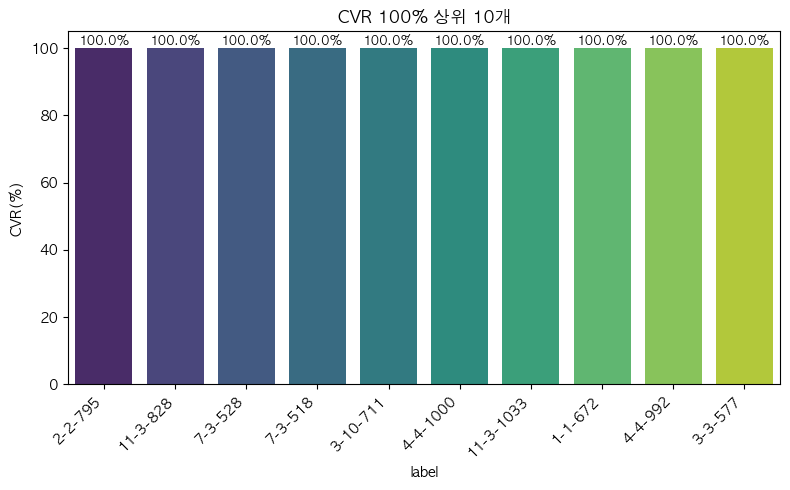

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. CVR 100% 조합만 필터링
cvr_100 = cvr_result[cvr_result["CVR(%)"] == 100].copy()

# 2. 반드시 포함할 조합 지정
must_include = [(11, 3, 828), (7, 3, 1031), (2, 2, 795)]

# 문자열 형태 라벨 생성
cvr_100["label"] = cvr_100[["ads_type","ads_category","mda_idx"]].astype(str).agg("-".join, axis=1)

# 3. 필수 조합 우선 포함
selected = cvr_100[cvr_100[["ads_type","ads_category","mda_idx"]].apply(tuple, axis=1).isin(must_include)]

# 4. 나머지 조합 채워서 총 10개
if len(selected) < 10:
    remaining = cvr_100.drop(selected.index).head(10 - len(selected))
    selected = pd.concat([selected, remaining])

# 5. 시각화
plt.figure(figsize=(8,5))
sns.barplot(
    data=selected,
    x="label", y="CVR(%)",
    palette="viridis"
)

plt.title("CVR 100% 상위 10개")
plt.xticks(rotation=45, ha="right")

# 막대 위에 값 표시
for i, v in enumerate(selected["CVR(%)"]):
    plt.text(i, v + 1, f"{v:.1f}%", ha="center", fontsize=9)

plt.tight_layout()
plt.show()


#### 전환율 하위 그래프

/var/folders/3m/40zzfh3x6ns8ym348ltj6b640000gn/T/ipykernel_59302/562386345.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


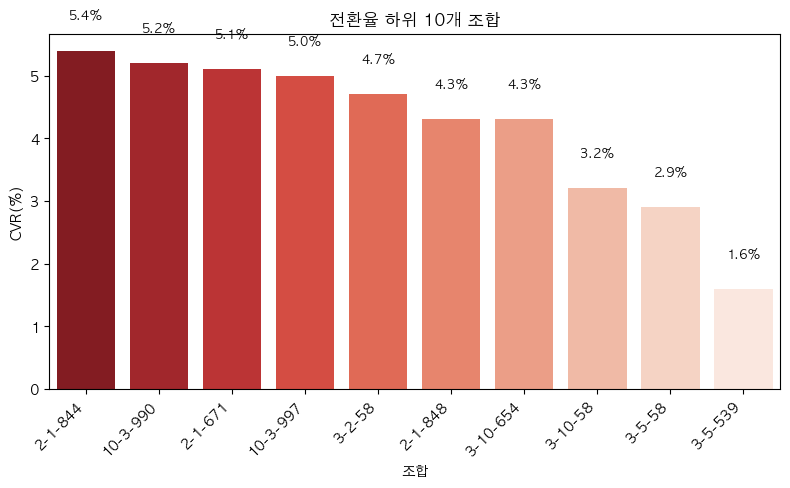

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# 하위 10개 추출
bottom10 = cvr_result.tail(10).copy()

# 조합 라벨 생성
bottom10["조합"] = bottom10[["ads_type","ads_category","mda_idx"]].astype(str).agg("-".join, axis=1)

# 히스토그램 (막대그래프)
plt.figure(figsize=(8,5))
sns.barplot(
    data=bottom10,
    x="조합", y="CVR(%)",
    palette="Reds_r"
)

plt.title("전환율 하위 10개 조합")
plt.xticks(rotation=45, ha="right")

# 막대 위에 값 표시
for i, v in enumerate(bottom10["CVR(%)"]):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha="center", fontsize=9)

plt.tight_layout()
plt.show()


### 1년치 마진율

In [29]:
# 타입 + 카테고리 + 매체 조합별 마진율 계산
margin_result = calc_margin_ratio(
    df=ad_hourly_df,
    group_cols=["ads_type", "ads_category", "mda_idx"],  # 그룹 기준
    earn_col="rpt_time_earn",    # 매출
    acost_col="rpt_time_acost",  # 비용
    as_percent=True,             # 퍼센트 변환
    decimals=1,                  # 소수점 자릿수
    drop_zero_acost_groups=True, # acost 합계 0인 그룹 제거
    sort_desc=True               # 마진율 내림차순 정렬
)

margin_result = margin_result.drop(columns=["earn_sum", "acost_sum","Margin"])

# 결과 확인
margin_result


,ads_type,ads_category,mda_idx,Margin_Rate(%)
0,12,11,1055,96.6
1,12,11,980,96.0
2,1,1,525,87.0
3,1,1,573,86.5
4,1,1,605,86.1
...,...,...,...,...
1656,1,2,58,4.4
1657,3,13,1061,4.3
1658,4,4,854,0.0
1659,4,4,787,0.0


#### 마진율 상위 그래프

/var/folders/3m/40zzfh3x6ns8ym348ltj6b640000gn/T/ipykernel_59302/2104078434.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


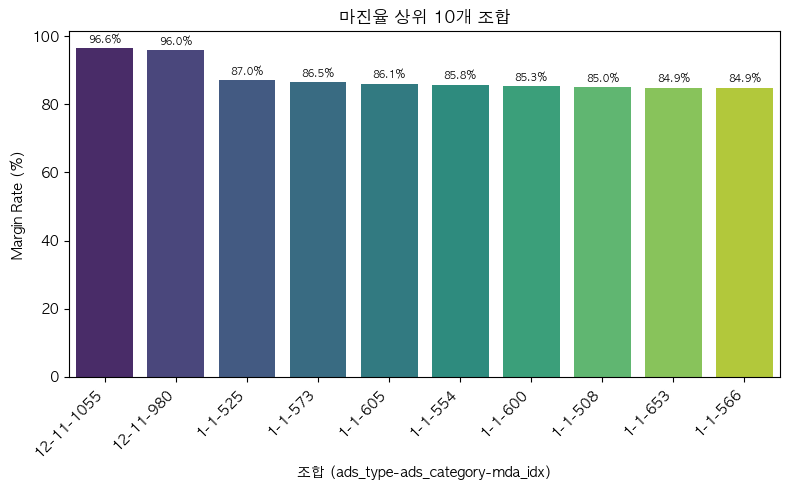

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# 상위 10개만 추출
top10_margin = margin_result.head(10).copy()

# 조합 레이블 생성 (ads_type-ads_category-mda_idx)
top10_margin["조합"] = top10_margin[["ads_type","ads_category","mda_idx"]].astype(str).agg("-".join, axis=1)

# 그래프 그리기
plt.figure(figsize=(8,5))
ax = sns.barplot(
    data=top10_margin,
    x="조합", y="Margin_Rate(%)",
    palette="viridis"
)

# 막대 위에 퍼센트 값 표시
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", label_type="edge", fontsize=7, padding=2)

plt.title("마진율 상위 10개 조합")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Margin Rate (%)")
plt.xlabel("조합 (ads_type-ads_category-mda_idx)")
plt.tight_layout()
plt.show()


#### 마진율 하위 그래프

/var/folders/3m/40zzfh3x6ns8ym348ltj6b640000gn/T/ipykernel_59302/274374340.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


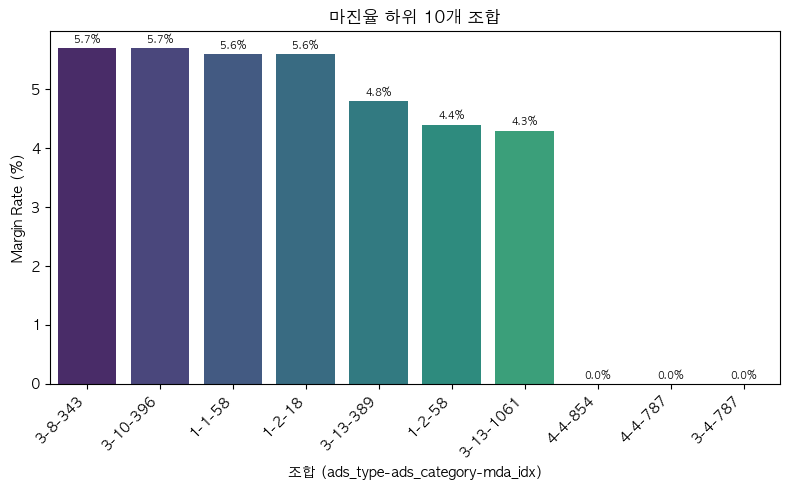

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# 상위 10개만 추출
top10_margin = margin_result.tail(10).copy()

# 조합 레이블 생성 (ads_type-ads_category-mda_idx)
top10_margin["조합"] = top10_margin[["ads_type","ads_category","mda_idx"]].astype(str).agg("-".join, axis=1)

# 그래프 그리기
plt.figure(figsize=(8,5))
ax = sns.barplot(
    data=top10_margin,
    x="조합", y="Margin_Rate(%)",
    palette="viridis"
)

# 막대 위에 퍼센트 값 표시
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", label_type="edge", fontsize=7, padding=2)

plt.title("마진율 하위 10개 조합")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Margin Rate (%)")
plt.xlabel("조합 (ads_type-ads_category-mda_idx)")
plt.tight_layout()
plt.show()


# 7-8월 데이터 비교분석

## 7-8월 상위 전환율

In [32]:
# 7-8월 상위 전환율
cvr_top_78_df

# 2-2-795, 11-3-828 조합 겹침


,ads_type_nm,ads_category_nm,mda_idx,rpt_time_clk,rpt_time_turn,CVR_rate,CVR
0,7,3,1031.0,NaN,NaN,NaN,NaN
1,2,2,795.0,NaN,NaN,NaN,NaN
2,11,3,828.0,NaN,NaN,NaN,NaN
3,2,2,1047.0,13.0,13.0,1.0,100.0
4,2,2,1046.0,11.0,11.0,1.0,100.0
5,11,3,337.0,6.0,6.0,1.0,100.0
6,4,4,270.0,54.0,54.0,1.0,100.0
7,4,1,246.0,3.0,3.0,1.0,100.0
8,3,1,246.0,3.0,3.0,1.0,100.0
9,4,1,371.0,61.0,61.0,1.0,100.0


### 7-8월과 1년치에서 겹치는 조합 시계열 확인

#### 2-2-795, 11-3-828 조합 시계열

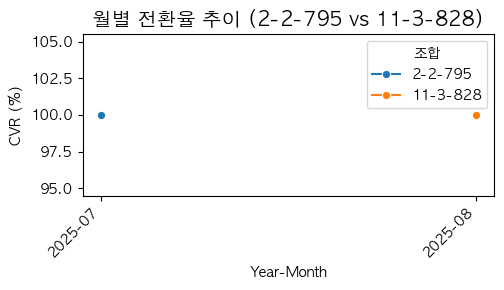

In [33]:
# 분석 대상
targets = [(2, 2, 795), (11, 3, 828)]
subset = ad_hourly_df[ad_hourly_df[["ads_type", "ads_category", "mda_idx"]]
                      .apply(tuple, axis=1).isin(targets)]

# 월별 CVR 계산
cvr_ts = calc_cvr_by_month(
    subset,
    group_cols=["ads_type", "ads_category", "mda_idx"],
    date_col="rpt_time_date",
    turn_col="rpt_time_turn",
    clk_col="rpt_time_clk",
    as_percent=True,
    decimals=1,
    drop_zero_click_groups=True
)

# 라벨 생성
cvr_ts["label"] = cvr_ts[["ads_type", "ads_category", "mda_idx"]].astype(str).agg("-".join, axis=1)

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,3))
sns.lineplot(
    data=cvr_ts,
    x="year_month", y="CVR(%)",
    hue="label", marker="o"
)

plt.title("월별 전환율 추이 (2-2-795 vs 11-3-828)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.ylabel("CVR (%)")
plt.xlabel("Year-Month")
plt.legend(title="조합", loc="best")
plt.tight_layout()
plt.show()


### 7-8월과 1년치에서 안겹치는 조합
#### 7-3-528, 7-3-518, 3-10-711, 4-4-1000, 11-3-1033, 1-1-672, 4-4-992, 3-3-577

### 안겹치는 조합 시계열

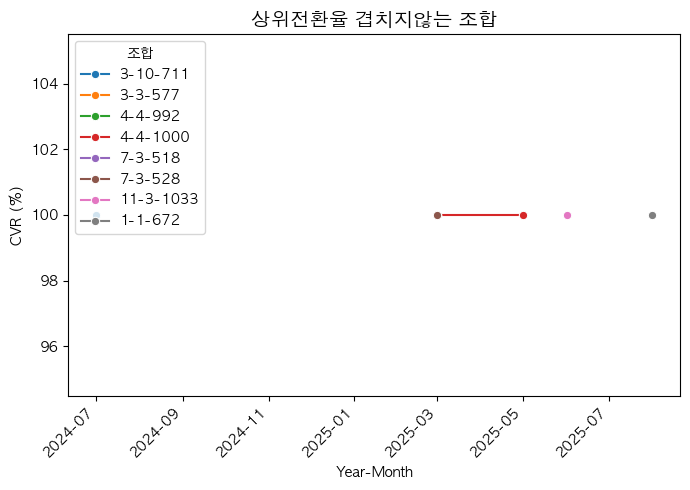

In [34]:
# 분석 대상 (친구 데이터에는 있고 내 데이터엔 없었던 조합들)
targets = [
    (7, 3, 528), (7, 3, 518), (3, 10, 711), (4, 4, 1000),
    (11, 3, 1033), (1, 1, 672), (4, 4, 992), (3, 3, 577)
]

# 해당 조합 필터링
subset = ad_hourly_df[ad_hourly_df[["ads_type", "ads_category", "mda_idx"]]
                      .apply(tuple, axis=1).isin(targets)]

# 월별 CVR 계산
cvr_ts = calc_cvr_by_month(
    subset,
    group_cols=["ads_type", "ads_category", "mda_idx"],
    date_col="rpt_time_date",
    turn_col="rpt_time_turn",
    clk_col="rpt_time_clk",
    as_percent=True,
    decimals=1,
    drop_zero_click_groups=True
)

# 라벨 생성 (ads_type-ads_category-mda_idx)
cvr_ts["label"] = cvr_ts[["ads_type", "ads_category", "mda_idx"]]\
                        .astype(str).agg("-".join, axis=1)

# year_month를 datetime으로 변환해서 정렬
cvr_ts["year_month"] = pd.to_datetime(cvr_ts["year_month"])

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,5))
sns.lineplot(
    data=cvr_ts.sort_values("year_month"),
    x="year_month", y="CVR(%)",
    hue="label", marker="o"
)

plt.title("상위전환율 겹치지않는 조합", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.ylabel("CVR (%)")
plt.xlabel("Year-Month")
plt.legend(title="조합", loc="best")
plt.tight_layout()
plt.show()


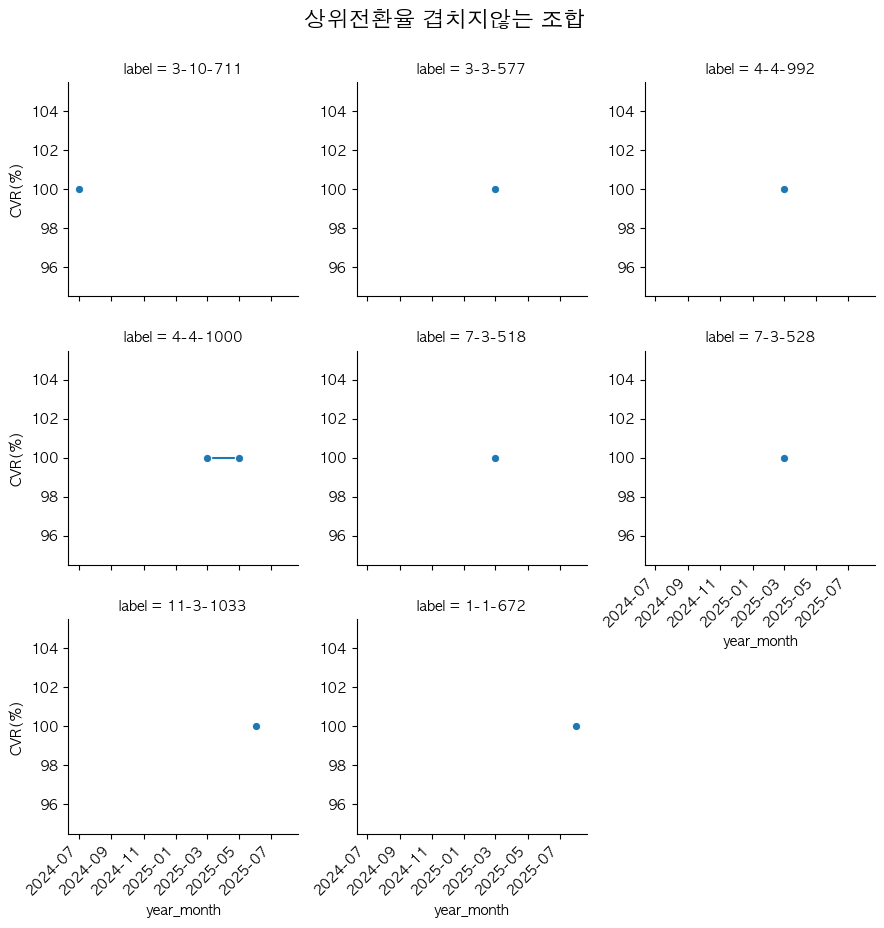

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 분석 대상 (친구 데이터에는 있고 내 데이터엔 없었던 조합들)
targets = [
    (7, 3, 528), (7, 3, 518), (3, 10, 711), (4, 4, 1000),
    (11, 3, 1033), (1, 1, 672), (4, 4, 992), (3, 3, 577)
]

# 해당 조합 필터링
subset = ad_hourly_df[ad_hourly_df[["ads_type", "ads_category", "mda_idx"]]
                      .apply(tuple, axis=1).isin(targets)]

# 월별 CVR 계산
cvr_ts = calc_cvr_by_month(
    subset,
    group_cols=["ads_type", "ads_category", "mda_idx"],
    date_col="rpt_time_date",
    turn_col="rpt_time_turn",
    clk_col="rpt_time_clk",
    as_percent=True,
    decimals=1,
    drop_zero_click_groups=True
)

# 라벨 생성
cvr_ts["label"] = cvr_ts[["ads_type", "ads_category", "mda_idx"]]\
                        .astype(str).agg("-".join, axis=1)

# year_month를 datetime으로 변환해서 정렬
cvr_ts["year_month"] = pd.to_datetime(cvr_ts["year_month"])
cvr_ts = cvr_ts.sort_values("year_month")

# FacetGrid로 조합별 개별 그래프 생성
g = sns.FacetGrid(cvr_ts, col="label", col_wrap=3, height=3, sharey=False)
g.map_dataframe(sns.lineplot, x="year_month", y="CVR(%)", marker="o")

# 각 그래프 X축 라벨 회전
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("상위전환율 겹치지않는 조합", fontsize=16)
plt.show()


### 안겹치는 조합 다른매체와의 전환율 시계열

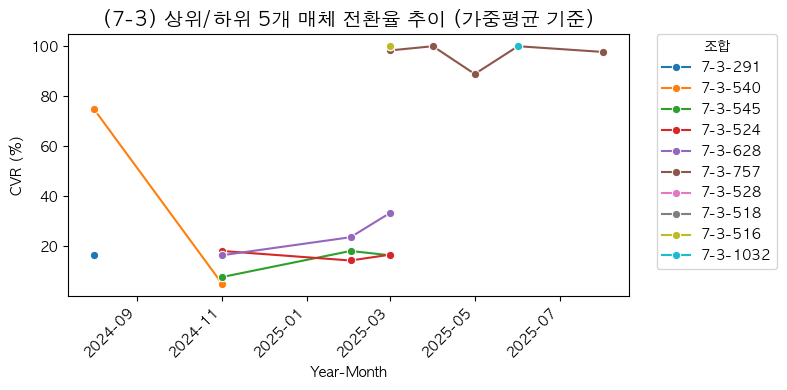

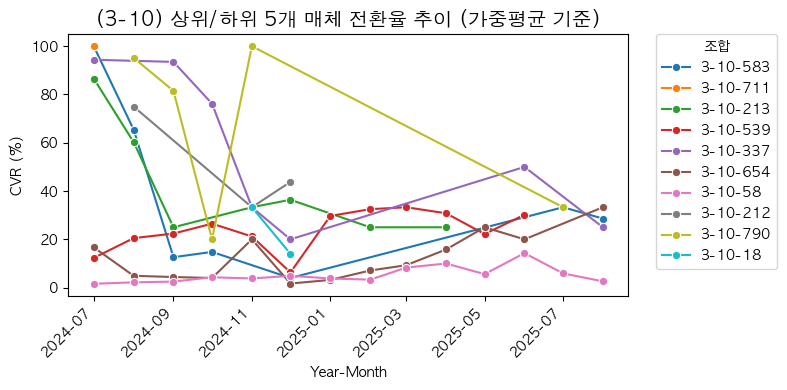

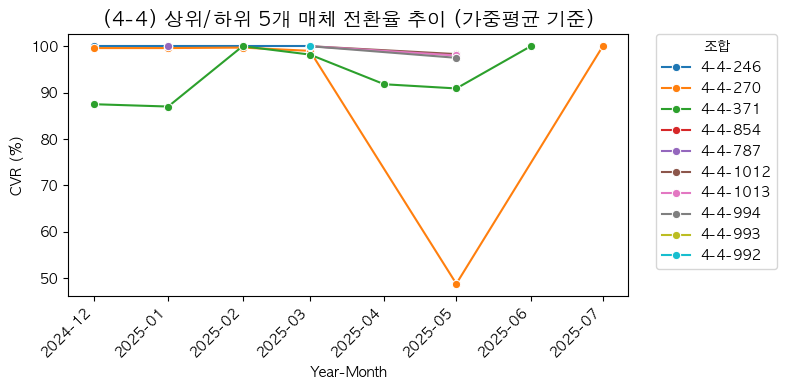

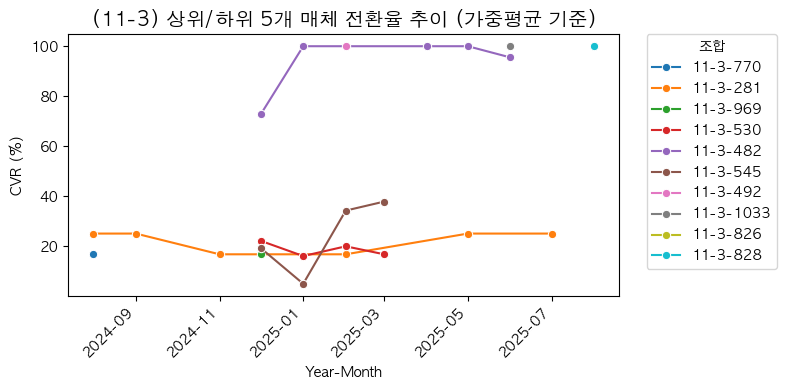

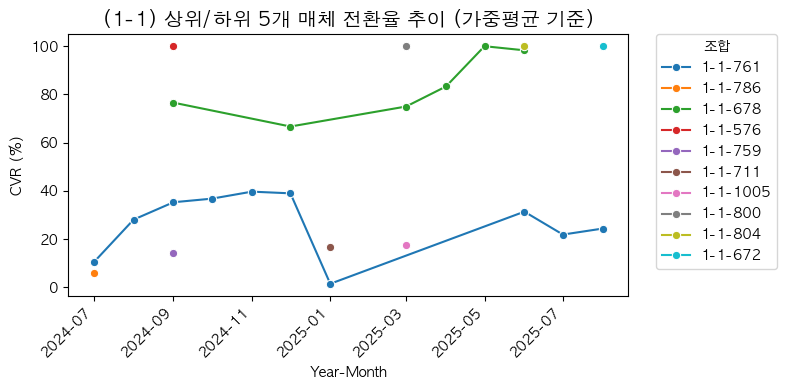

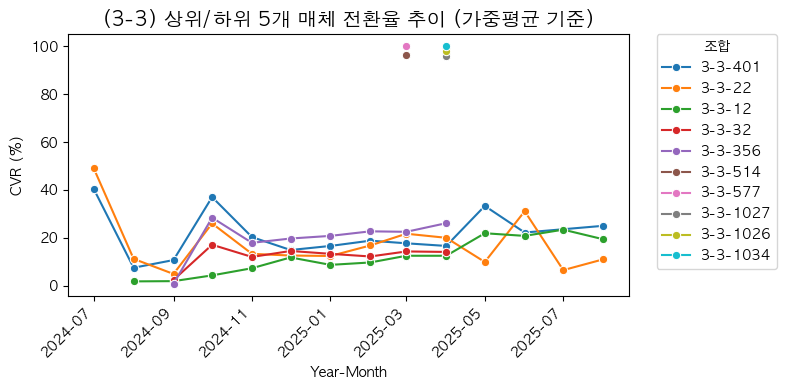

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 분석 대상 (친구 데이터에서만 있었던 조합들의 type-category 묶음)
target_pairs = [(7, 3), (3, 10), (4, 4), (11, 3), (1, 1), (3, 3)]

for pair in target_pairs:
    # 1. 해당 그룹 데이터 필터링
    subset_pair = ad_hourly_df[
        (ad_hourly_df["ads_type"] == pair[0]) &
        (ad_hourly_df["ads_category"] == pair[1])
    ]

    if subset_pair.empty:
        print(f"({pair[0]}-{pair[1]}) 데이터 없음")
        continue

    # 2. 월별 CVR 계산
    cvr_pair = calc_cvr_by_month(
        subset_pair,
        group_cols=["ads_type", "ads_category", "mda_idx"],
        date_col="rpt_time_date",
        turn_col="rpt_time_turn",
        clk_col="rpt_time_clk",
        as_percent=True,
        decimals=1,
        drop_zero_click_groups=True
    )

    # year_month를 datetime으로 변환해서 정렬
    cvr_pair["year_month"] = pd.to_datetime(cvr_pair["year_month"])
    cvr_pair = cvr_pair.sort_values("year_month")

    # 3. 매체별 전체기간 가중평균 CVR 계산
    weighted_cvr = (
        cvr_pair.groupby(["ads_type", "ads_category", "mda_idx"])[["turn_sum", "clk_sum"]]
        .sum()
        .reset_index()
    )
    weighted_cvr["CVR(%)"] = (weighted_cvr["turn_sum"] / weighted_cvr["clk_sum"] * 100).round(1)

    # Top5 / Bottom5 선정
    top5 = weighted_cvr.nlargest(5, "CVR(%)")["mda_idx"].tolist()
    bottom5 = weighted_cvr.nsmallest(5, "CVR(%)")["mda_idx"].tolist()
    selected_mda = top5 + bottom5

    # 4. 시각화 데이터 준비
    filtered = cvr_pair[cvr_pair["mda_idx"].isin(selected_mda)].copy()
    filtered["label"] = filtered[["ads_type", "ads_category", "mda_idx"]]\
                            .astype(str).agg("-".join, axis=1)

    # 5. 시각화
    plt.figure(figsize=(8,4))
    sns.lineplot(
        data=filtered,
        x="year_month", y="CVR(%)",
        hue="label", marker="o"
    )

    plt.title(f"({pair[0]}-{pair[1]}) 상위/하위 5개 매체 전환율 추이 (가중평균 기준)", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("CVR (%)")
    plt.xlabel("Year-Month")
    plt.legend(title="조합", loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0)
    plt.tight_layout()
    plt.show()


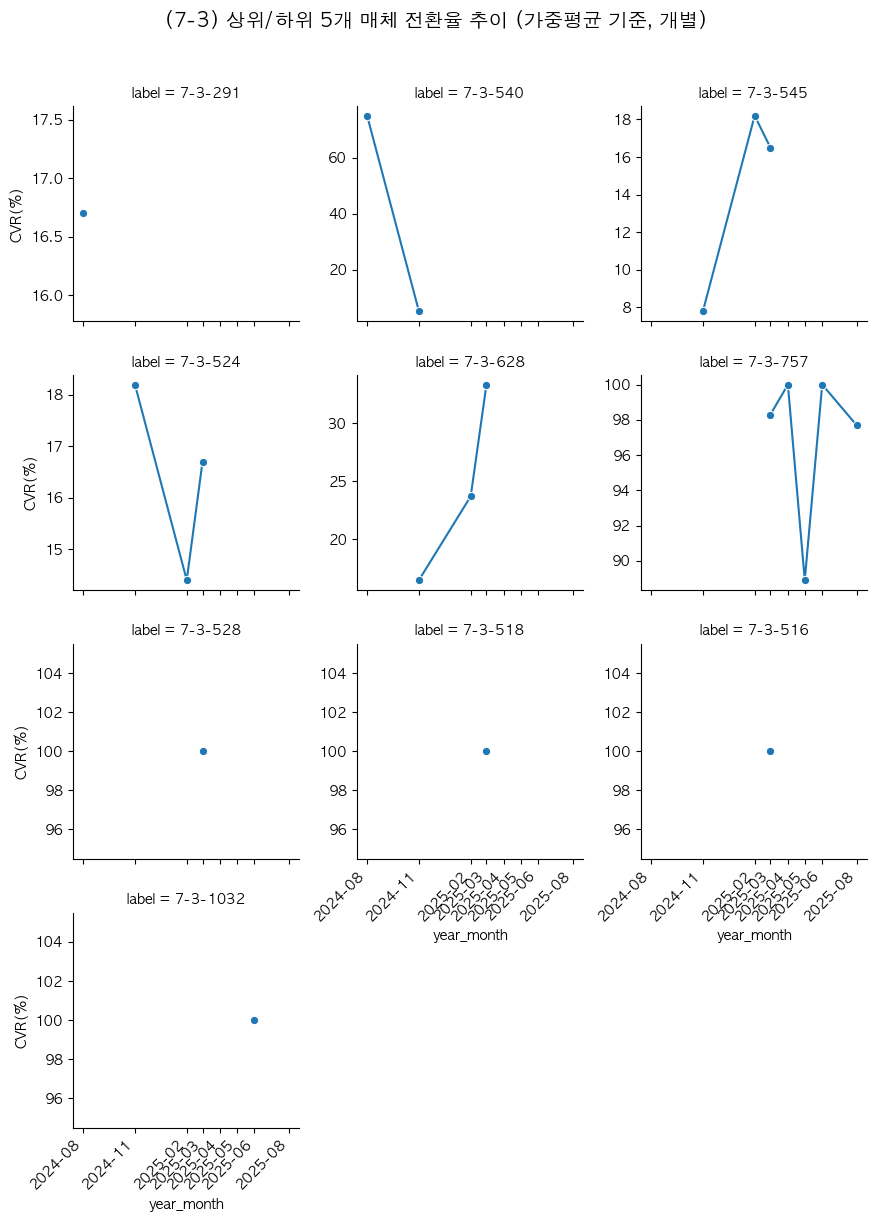

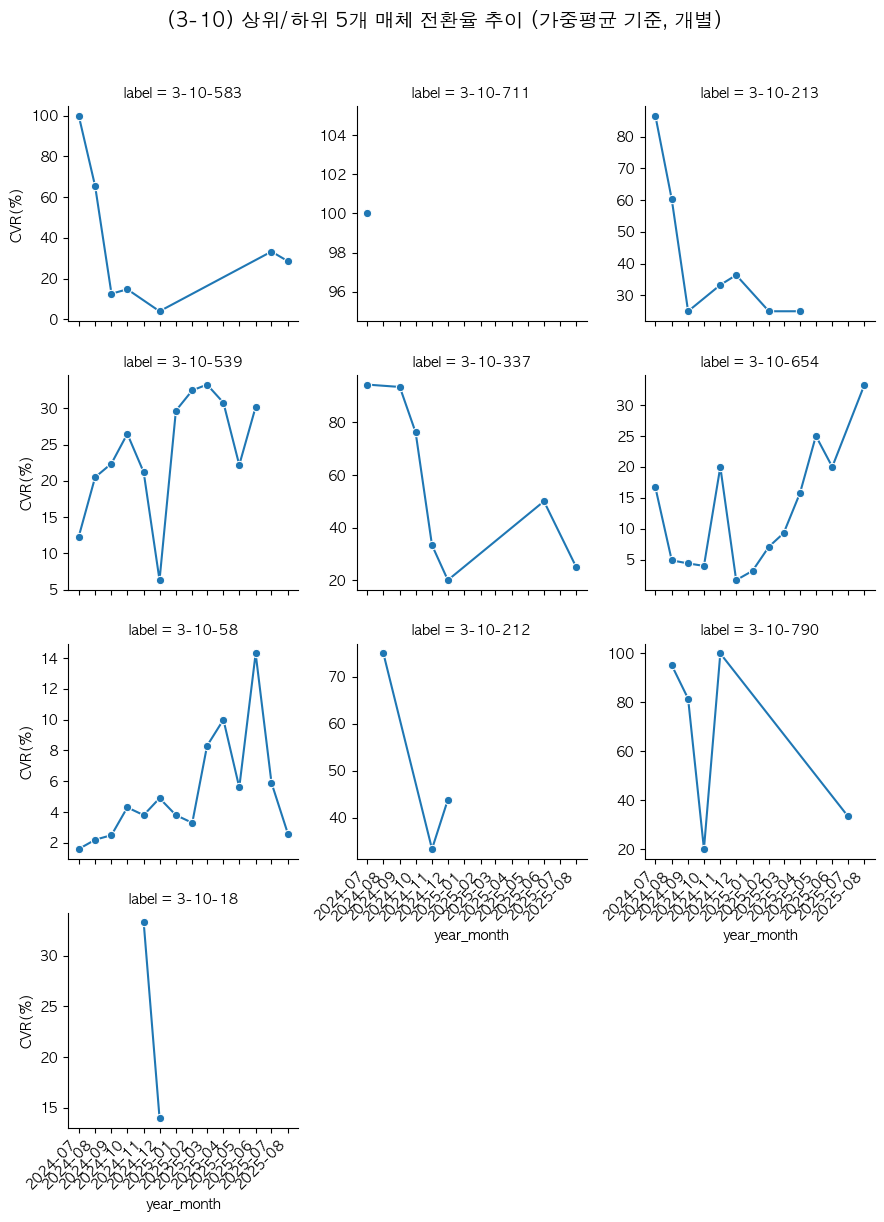

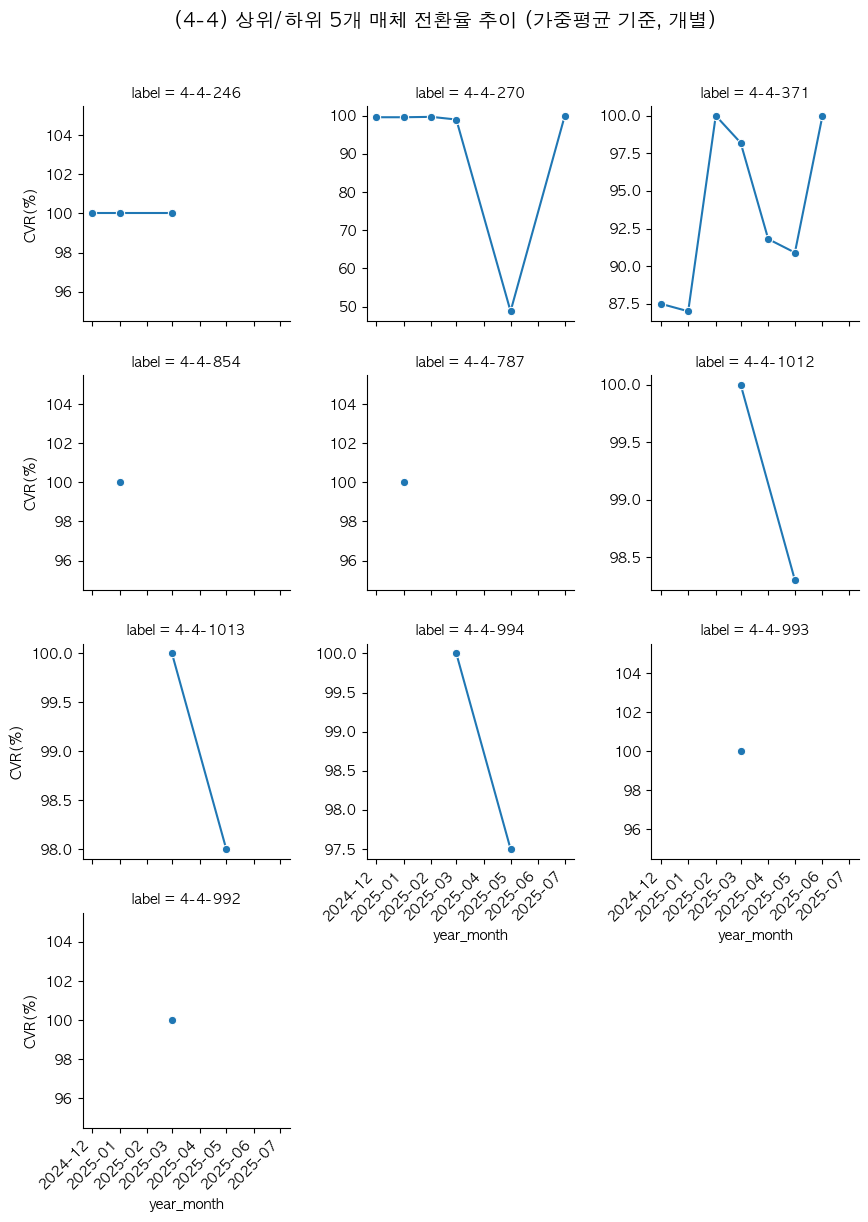

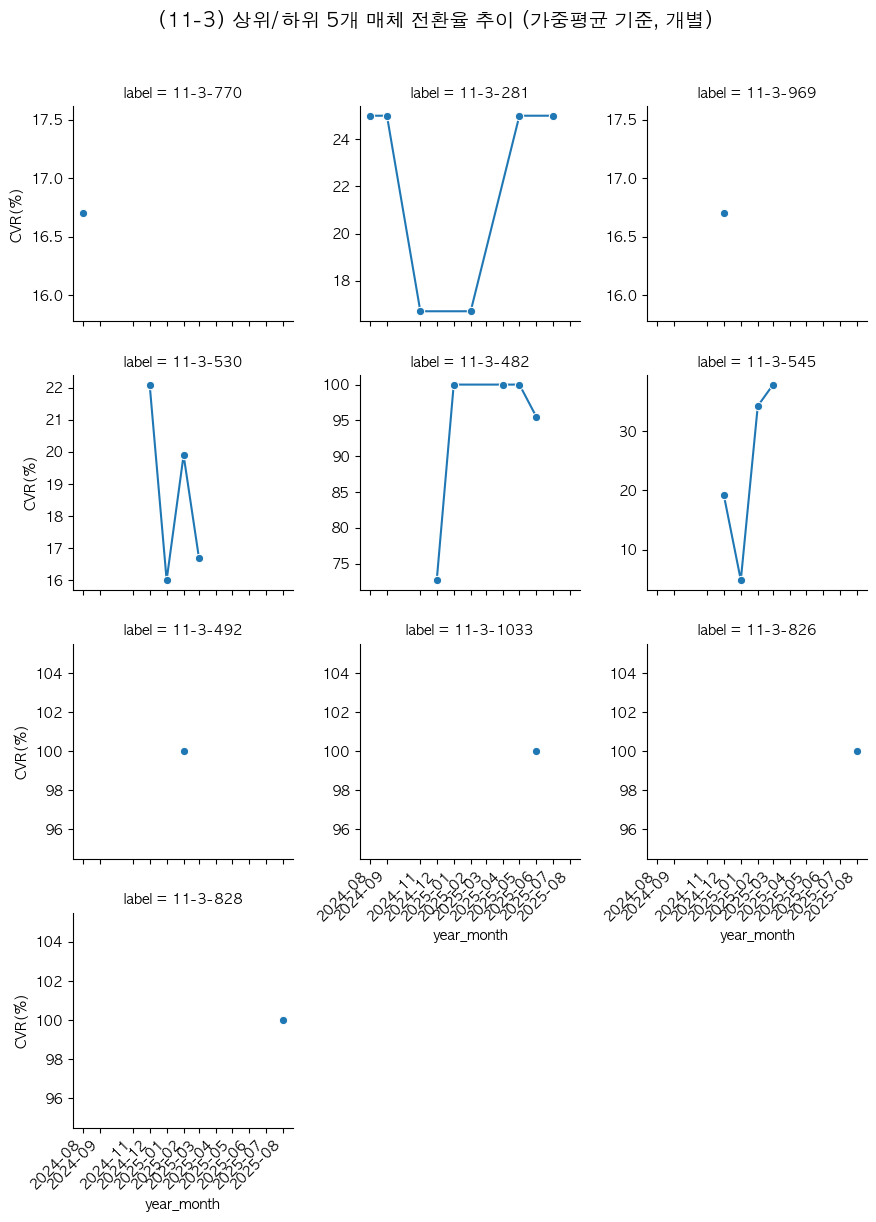

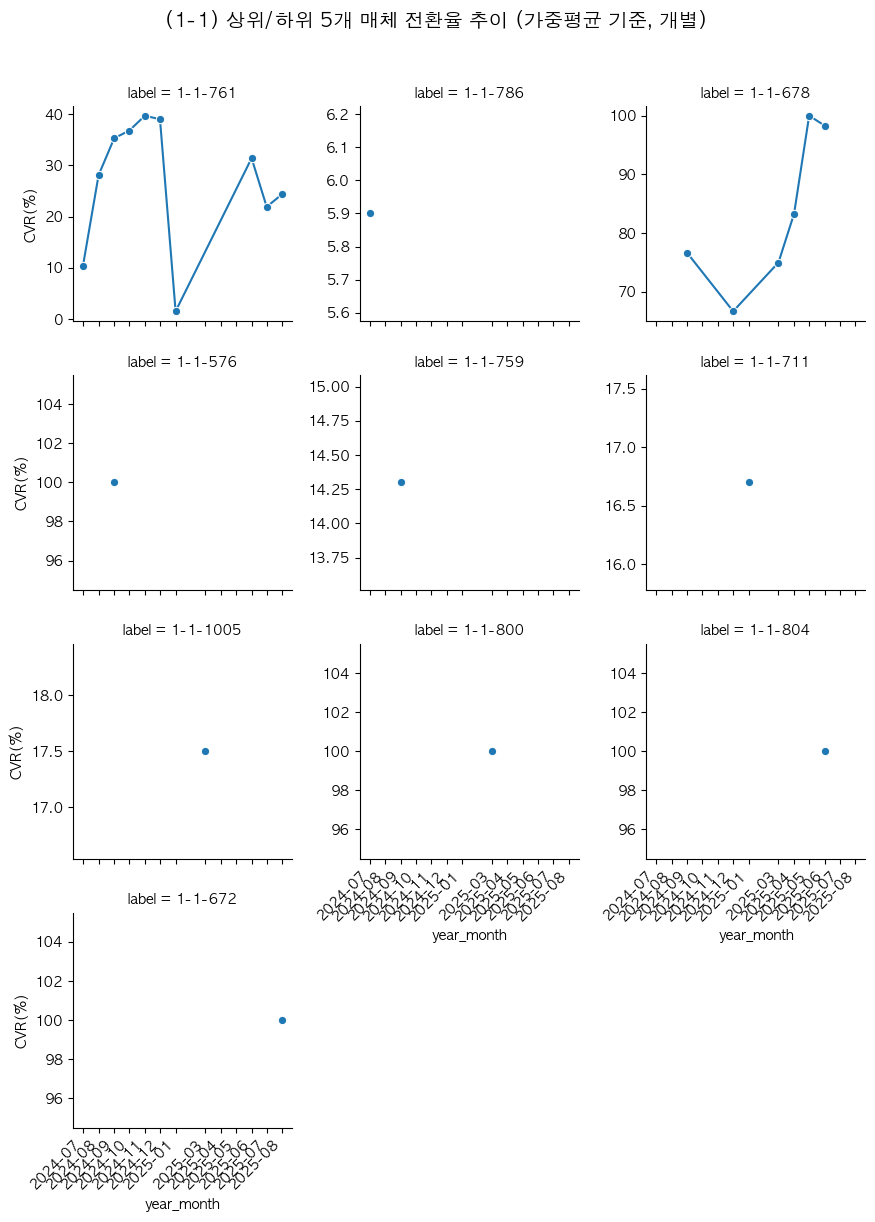

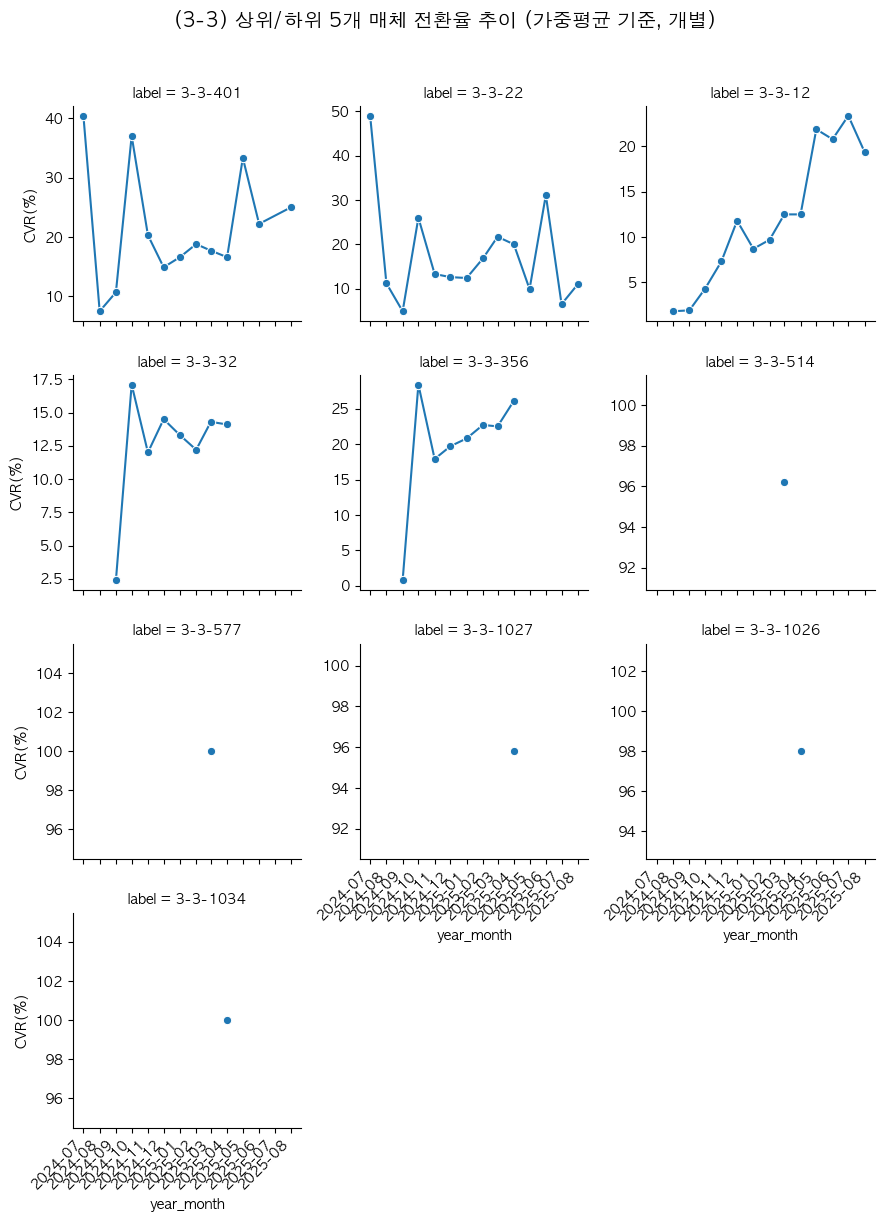

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 분석 대상 (친구 데이터에서만 있었던 조합들의 type-category 묶음)
target_pairs = [(7, 3), (3, 10), (4, 4), (11, 3), (1, 1), (3, 3)]

for pair in target_pairs:
    # 1. 해당 그룹 데이터 필터링
    subset_pair = ad_hourly_df[
        (ad_hourly_df["ads_type"] == pair[0]) &
        (ad_hourly_df["ads_category"] == pair[1])
    ]

    if subset_pair.empty:
        print(f"({pair[0]}-{pair[1]}) 데이터 없음")
        continue

    # 2. 월별 CVR 계산
    cvr_pair = calc_cvr_by_month(
        subset_pair,
        group_cols=["ads_type", "ads_category", "mda_idx"],
        date_col="rpt_time_date",
        turn_col="rpt_time_turn",
        clk_col="rpt_time_clk",
        as_percent=True,
        decimals=1,
        drop_zero_click_groups=True
    )

    # year_month 변환 & 정렬
    cvr_pair["year_month"] = pd.to_datetime(cvr_pair["year_month"])
    cvr_pair = cvr_pair.sort_values("year_month")

    # 3. 매체별 전체기간 가중평균 CVR 계산
    weighted_cvr = (
        cvr_pair.groupby(["ads_type", "ads_category", "mda_idx"])[["turn_sum", "clk_sum"]]
        .sum()
        .reset_index()
    )
    weighted_cvr["CVR(%)"] = (weighted_cvr["turn_sum"] / weighted_cvr["clk_sum"] * 100).round(1)

    # Top5 / Bottom5
    top5 = weighted_cvr.nlargest(5, "CVR(%)")["mda_idx"].tolist()
    bottom5 = weighted_cvr.nsmallest(5, "CVR(%)")["mda_idx"].tolist()
    selected_mda = top5 + bottom5

    # 4. 시각화 데이터 준비
    filtered = cvr_pair[cvr_pair["mda_idx"].isin(selected_mda)].copy()
    filtered["label"] = filtered[["ads_type", "ads_category", "mda_idx"]]\
                            .astype(str).agg("-".join, axis=1)

    # 공통 X축(months) 기준 생성
    all_months = filtered["year_month"].sort_values().unique()
    all_labels = pd.to_datetime(all_months).strftime("%Y-%m")

    # 5. FacetGrid 개별 그래프
    g = sns.FacetGrid(filtered, col="label", col_wrap=3, height=3, sharey=False)
    g.map_dataframe(sns.lineplot, x="year_month", y="CVR(%)", marker="o")

    # 모든 그래프에 동일한 X축 라벨 적용
    for ax in g.axes.flat:
        ax.set_xticks(all_months)
        ax.set_xticklabels(all_labels, rotation=45, ha="right")

    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f"({pair[0]}-{pair[1]}) 상위/하위 5개 매체 전환율 추이 (가중평균 기준, 개별)", fontsize=14)
    plt.show()


## 7-8월 하위 전환율

In [38]:
cvr_bottom_78_df


,ads_type_nm,ads_category_nm,mda_idx,rpt_time_clk,rpt_time_turn,CVR_rate,CVR
0,3,5,539.0,81215.0,70.0,0.000862,0.1
1,3,10,58.0,289.0,8.0,0.027682,2.8
2,2,2,990.0,117.0,4.0,0.034188,3.4
3,2,1,848.0,1553.0,67.0,0.043142,4.3
4,3,5,58.0,4765.0,204.0,0.042812,4.3
5,3,7,58.0,622.0,29.0,0.046624,4.7
6,3,8,12.0,24315.0,1198.0,0.049270,4.9
7,1,2,634.0,20.0,1.0,0.050000,5.0
8,2,1,671.0,353.0,18.0,0.050992,5.1
9,2,1,844.0,56.0,3.0,0.053571,5.4


### 7-8월과 1년치에서 겹치는 조합 시계열 확인
#### 2-1-844, 2-1-671, 2-1-848, 3-10-58, 3-5-58, 3-5-539

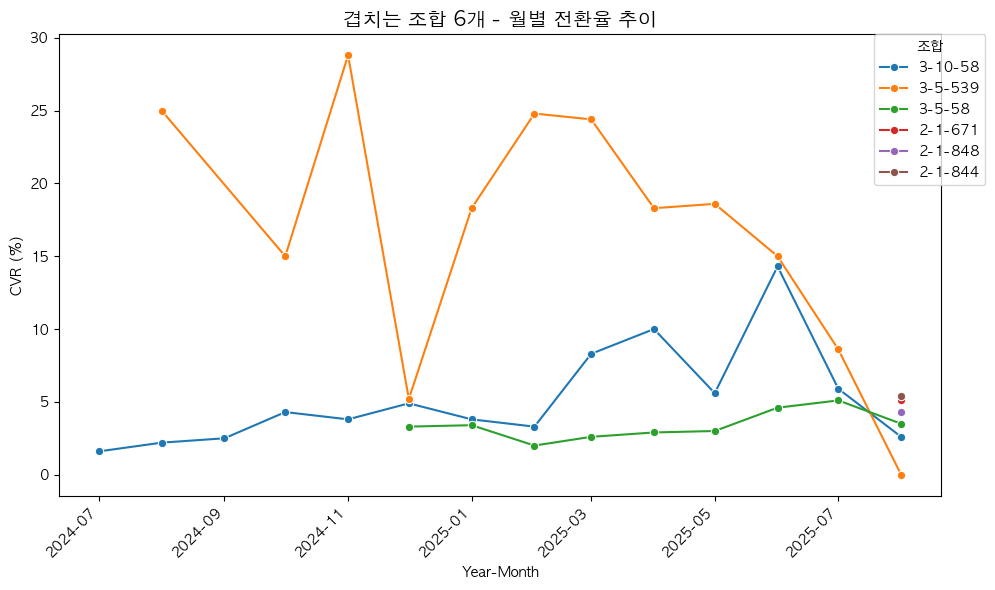

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 분석 대상 (겹치는 조합 6개)
targets = [
    (2, 1, 844), (2, 1, 671), (2, 1, 848),
    (3, 10, 58), (3, 5, 58), (3, 5, 539)
]

# 해당 조합 필터링
subset = ad_hourly_df[ad_hourly_df[["ads_type", "ads_category", "mda_idx"]]
                      .apply(tuple, axis=1).isin(targets)]

# 월별 CVR 계산
cvr_ts = calc_cvr_by_month(
    subset,
    group_cols=["ads_type", "ads_category", "mda_idx"],
    date_col="rpt_time_date",
    turn_col="rpt_time_turn",
    clk_col="rpt_time_clk",
    as_percent=True,
    decimals=1,
    drop_zero_click_groups=True
)

# 라벨 생성
cvr_ts["label"] = cvr_ts[["ads_type", "ads_category", "mda_idx"]]\
                        .astype(str).agg("-".join, axis=1)

# year_month를 datetime으로 변환해서 정렬
cvr_ts["year_month"] = pd.to_datetime(cvr_ts["year_month"])
cvr_ts = cvr_ts.sort_values("year_month")

# 시각화
plt.figure(figsize=(10,6))
sns.lineplot(
    data=cvr_ts,
    x="year_month", y="CVR(%)",
    hue="label", marker="o"
)

plt.title("겹치는 조합 6개 - 월별 전환율 추이", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.ylabel("CVR (%)")
plt.xlabel("Year-Month")
plt.legend(title="조합", loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0)
plt.tight_layout()
plt.show()


### 7-8월과 1년치에서 안겹치는 조합
#### 2-2-990, 3-7-58, 3-8-12, 2-2-634

### 안겹치는 조합 시계열

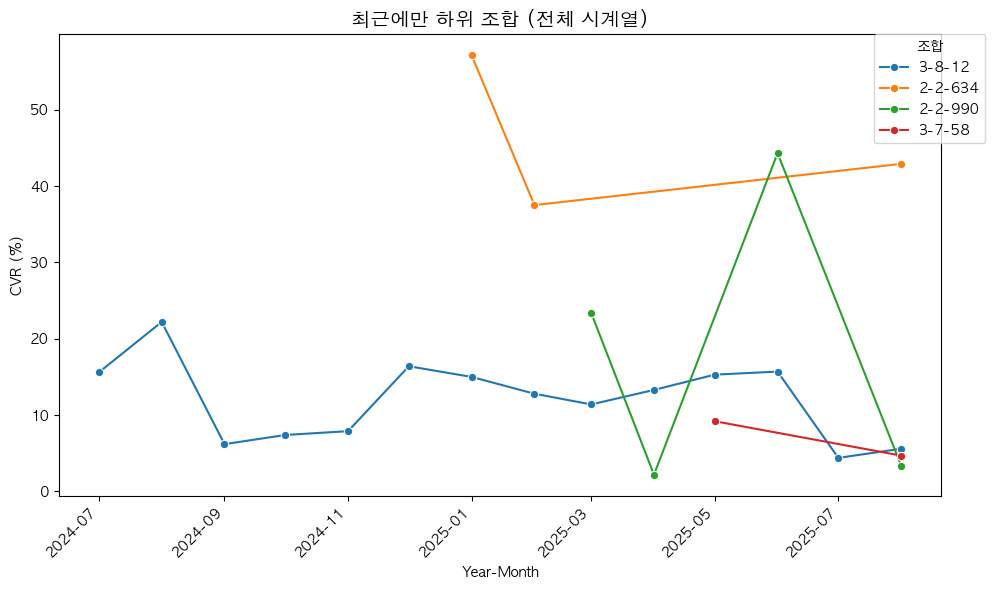

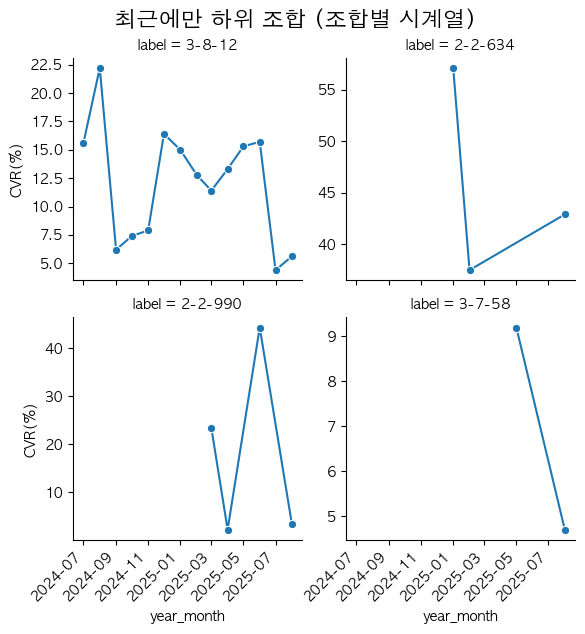

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 분석 대상 (사진에는 없고 표에만 있었던 조합들)
targets = [
    (2, 2, 990), (3, 7, 58), (3, 8, 12), (2, 2, 634)
]

# 해당 조합 필터링
subset = ad_hourly_df[ad_hourly_df[["ads_type", "ads_category", "mda_idx"]]
                      .apply(tuple, axis=1).isin(targets)]

# 월별 CVR 계산
cvr_ts = calc_cvr_by_month(
    subset,
    group_cols=["ads_type", "ads_category", "mda_idx"],
    date_col="rpt_time_date",
    turn_col="rpt_time_turn",
    clk_col="rpt_time_clk",
    as_percent=True,
    decimals=1,
    drop_zero_click_groups=True
)

# 라벨 생성
cvr_ts["label"] = cvr_ts[["ads_type", "ads_category", "mda_idx"]]\
                        .astype(str).agg("-".join, axis=1)

# year_month를 datetime으로 변환해서 정렬
cvr_ts["year_month"] = pd.to_datetime(cvr_ts["year_month"])
cvr_ts = cvr_ts.sort_values("year_month")

# 1️⃣ 한 화면에 다 같이 그리는 그래프
plt.figure(figsize=(10,6))
sns.lineplot(
    data=cvr_ts,
    x="year_month", y="CVR(%)",
    hue="label", marker="o"
)

plt.title("최근에만 하위 조합 (전체 시계열)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.ylabel("CVR (%)")
plt.xlabel("Year-Month")
plt.legend(title="조합", loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0)
plt.tight_layout()
plt.show()

# 2️⃣ 조합별로 작게 나오는 그래프 (FacetGrid)
g = sns.FacetGrid(cvr_ts, col="label", col_wrap=2, height=3, sharey=False)
g.map_dataframe(sns.lineplot, x="year_month", y="CVR(%)", marker="o")

# 각 그래프 X축 라벨 회전
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("최근에만 하위 조합 (조합별 시계열)", fontsize=16)
plt.show()


### 안겹치는 조합 다른매체와의 조합 비교

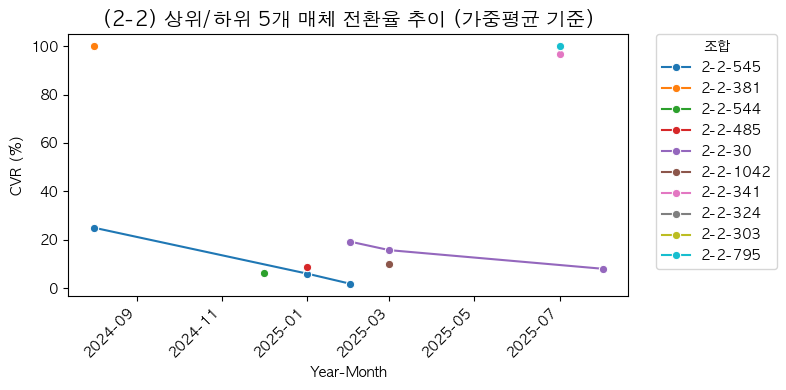

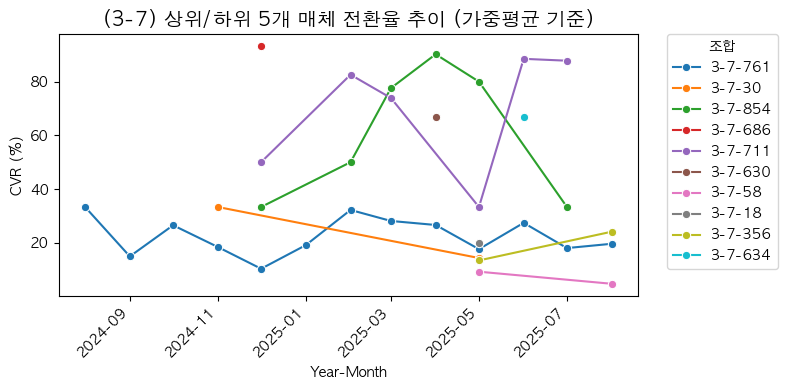

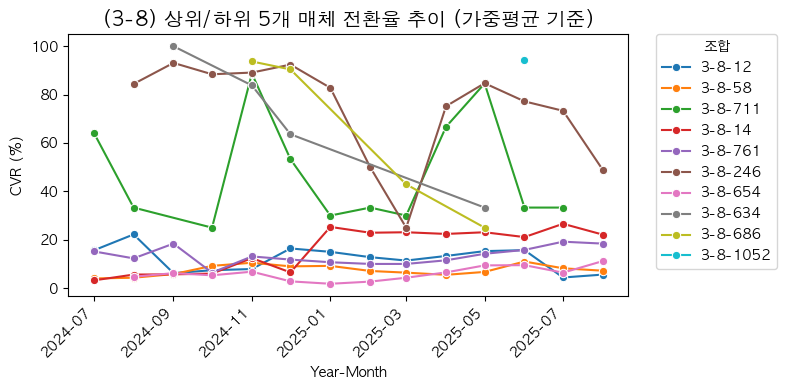

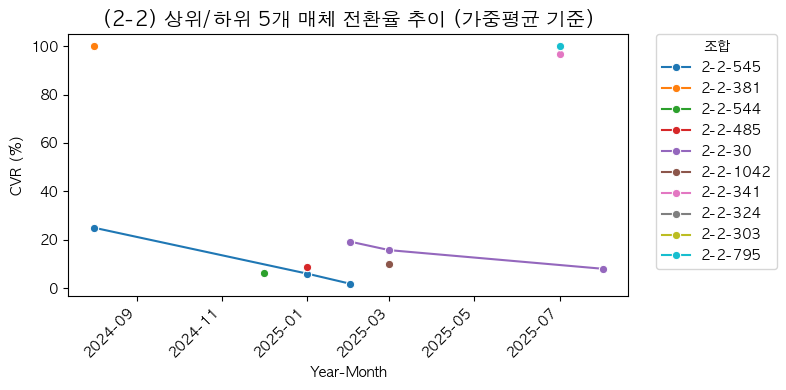

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 분석 대상 (표에는 있었지만 사진에는 없던 조합들의 type-category 묶음)
target_pairs = [(2, 2), (3, 7), (3, 8), (2, 2)]  # 중복 (2,2)는 자동으로 두 번 돌아도 됨

for pair in target_pairs:
    # 1. 해당 그룹 데이터 필터링
    subset_pair = ad_hourly_df[
        (ad_hourly_df["ads_type"] == pair[0]) &
        (ad_hourly_df["ads_category"] == pair[1])
    ]

    # 데이터 없으면 스킵
    if subset_pair.empty:
        print(f"({pair[0]}-{pair[1]}) 데이터 없음")
        continue

    # 2. 월별 CVR 계산
    cvr_pair = calc_cvr_by_month(
        subset_pair,
        group_cols=["ads_type", "ads_category", "mda_idx"],
        date_col="rpt_time_date",
        turn_col="rpt_time_turn",
        clk_col="rpt_time_clk",
        as_percent=True,
        decimals=1,
        drop_zero_click_groups=True
    )

    # year_month를 datetime으로 변환해서 정렬
    cvr_pair["year_month"] = pd.to_datetime(cvr_pair["year_month"])
    cvr_pair = cvr_pair.sort_values("year_month")

    # 3. 매체별 전체기간 가중평균 CVR 계산
    weighted_cvr = (
        cvr_pair.groupby(["ads_type", "ads_category", "mda_idx"])[["turn_sum", "clk_sum"]]
        .sum()
        .reset_index()
    )
    weighted_cvr["CVR(%)"] = (weighted_cvr["turn_sum"] / weighted_cvr["clk_sum"] * 100).round(1)

    # Top5 / Bottom5
    top5 = weighted_cvr.nlargest(5, "CVR(%)")["mda_idx"].tolist()
    bottom5 = weighted_cvr.nsmallest(5, "CVR(%)")["mda_idx"].tolist()
    selected_mda = top5 + bottom5

    # 4. 시각화 데이터 준비
    filtered = cvr_pair[cvr_pair["mda_idx"].isin(selected_mda)].copy()
    filtered["label"] = filtered[["ads_type", "ads_category", "mda_idx"]]\
                            .astype(str).agg("-".join, axis=1)

    # 5. 시각화 (그룹별로 개별 그래프)
    plt.figure(figsize=(8,4))
    sns.lineplot(
        data=filtered,
        x="year_month", y="CVR(%)",
        hue="label", marker="o"
    )

    plt.title(f"({pair[0]}-{pair[1]}) 상위/하위 5개 매체 전환율 추이 (가중평균 기준)", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("CVR (%)")
    plt.xlabel("Year-Month")
    plt.legend(title="조합", loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0)
    plt.tight_layout()
    plt.show()


## 7-8월 상위 마진율

In [42]:
margin__top_78_df


,ads_type_nm,ads_category_nm,mda_idx,rpt_time_acost,rpt_time_earn,margin,margin_rate,margin_rate_pct
0,12,11,1055.0,438802.0,17130.0,421672.0,0.960962,96.1
1,12,11,980.0,292022917.0,11482353.0,280540564.0,0.960680,96.1
2,1,2,804.0,3880.0,660.0,3220.0,0.829897,83.0
3,1,2,1012.0,74220.0,12720.0,61500.0,0.828618,82.9
4,1,2,990.0,176300.0,30360.0,145940.0,0.827794,82.8
5,1,2,1016.0,50810.0,8730.0,42080.0,0.828183,82.8
6,1,2,1010.0,111990.0,19380.0,92610.0,0.826949,82.7
7,1,2,997.0,202590.0,35130.0,167460.0,0.826596,82.7
8,1,2,1013.0,128790.0,22350.0,106440.0,0.826462,82.6
9,1,2,760.0,102440.0,17970.0,84470.0,0.824580,82.5


### 7-8월과 1년치에서 겹치는 조합 시계열 확인
#### 12-11-1055, 12-11-980

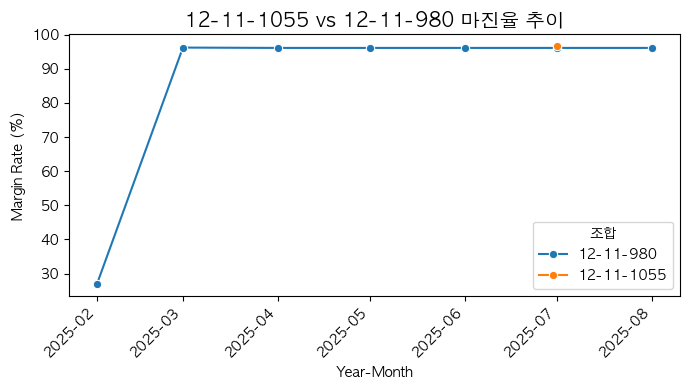

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 분석 대상
targets = [(12, 11, 1055), (12, 11, 980)]

# 해당 조합 필터링
subset = ad_hourly_df[ad_hourly_df[["ads_type", "ads_category", "mda_idx"]]
                      .apply(tuple, axis=1).isin(targets)]

# 월별 마진율 계산
margin_ts = calc_margin_by_month(
    subset,
    group_cols=["ads_type", "ads_category", "mda_idx"],
    earn_col="rpt_time_earn",
    acost_col="rpt_time_acost",
    date_col="rpt_time_date",
    as_percent=True,
    decimals=1,
    drop_zero_acost_groups=True
)

# year_month를 datetime으로 변환 후 정렬
margin_ts["year_month"] = pd.to_datetime(margin_ts["year_month"])
margin_ts = margin_ts.sort_values("year_month")

# 라벨 생성
margin_ts["label"] = margin_ts[["ads_type", "ads_category", "mda_idx"]]\
                           .astype(str).agg("-".join, axis=1)

# 시각화
plt.figure(figsize=(7,4))
sns.lineplot(
    data=margin_ts,
    x="year_month", y="Margin_Rate(%)",
    hue="label", marker="o"
)

plt.title("12-11-1055 vs 12-11-980 마진율 추이", fontsize=14)
plt.ylabel("Margin Rate (%)")
plt.xlabel("Year-Month")

# x축 라벨을 YYYY-MM으로 보기 좋게 표시
margin_ts["year_month_str"] = margin_ts["year_month"].dt.strftime("%Y-%m")
plt.gca().set_xticks(margin_ts["year_month"].unique())
plt.gca().set_xticklabels(margin_ts["year_month_str"].unique(), rotation=45, ha="right")

plt.legend(title="조합", loc="best")
plt.tight_layout()
plt.show()


### 7-8월과 1년치에서 안겹치는 조합
#### 1-2-804, 1-2-1012, 1-2-990, 1-2-1016, 1-2-1010, 1-2-997, 1-2-1013, 1-2-760

### 안겹치는 조합 시계열

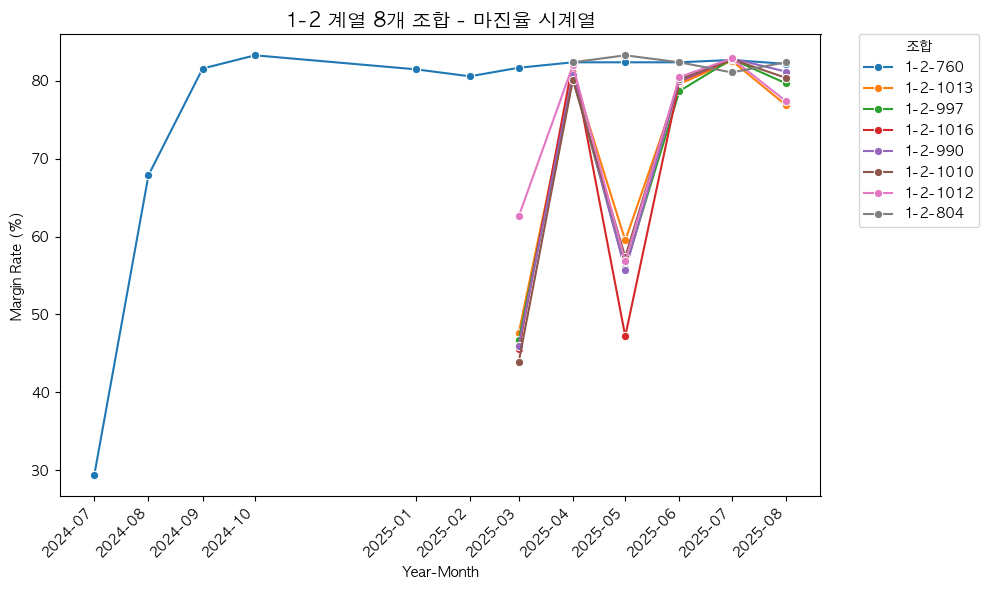

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 분석 대상
targets = [
    (1, 2, 804), (1, 2, 1012), (1, 2, 990), (1, 2, 1016),
    (1, 2, 1010), (1, 2, 997), (1, 2, 1013), (1, 2, 760)
]

# 해당 조합 필터링
subset = ad_hourly_df[ad_hourly_df[["ads_type", "ads_category", "mda_idx"]]
                      .apply(tuple, axis=1).isin(targets)]

# 월별 마진율 계산
margin_ts = calc_margin_by_month(
    subset,
    group_cols=["ads_type", "ads_category", "mda_idx"],
    earn_col="rpt_time_earn",
    acost_col="rpt_time_acost",
    date_col="rpt_time_date",
    as_percent=True,
    decimals=1,
    drop_zero_acost_groups=True
)

# year_month를 datetime으로 변환 후 정렬
margin_ts["year_month"] = pd.to_datetime(margin_ts["year_month"])
margin_ts = margin_ts.sort_values("year_month")

# 라벨 생성
margin_ts["label"] = margin_ts[["ads_type", "ads_category", "mda_idx"]]\
                           .astype(str).agg("-".join, axis=1)

# 시각화
plt.figure(figsize=(10,6))
sns.lineplot(
    data=margin_ts,
    x="year_month", y="Margin_Rate(%)",
    hue="label", marker="o"
)

plt.title("1-2 계열 8개 조합 - 마진율 시계열", fontsize=14)
plt.ylabel("Margin Rate (%)")
plt.xlabel("Year-Month")

# x축 라벨을 YYYY-MM으로 보기 좋게 표시
margin_ts["year_month_str"] = margin_ts["year_month"].dt.strftime("%Y-%m")
plt.gca().set_xticks(margin_ts["year_month"].unique())
plt.gca().set_xticklabels(margin_ts["year_month_str"].unique(), rotation=45, ha="right")

plt.legend(title="조합", loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0)
plt.tight_layout()
plt.show()


### 안겹치는 조합 다른매체와의 마진율 확인

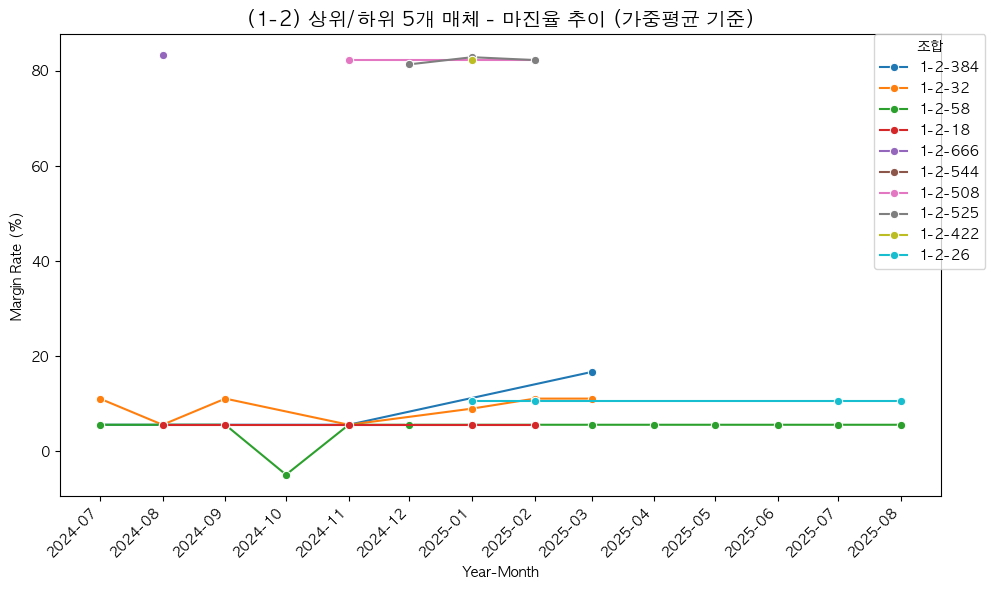

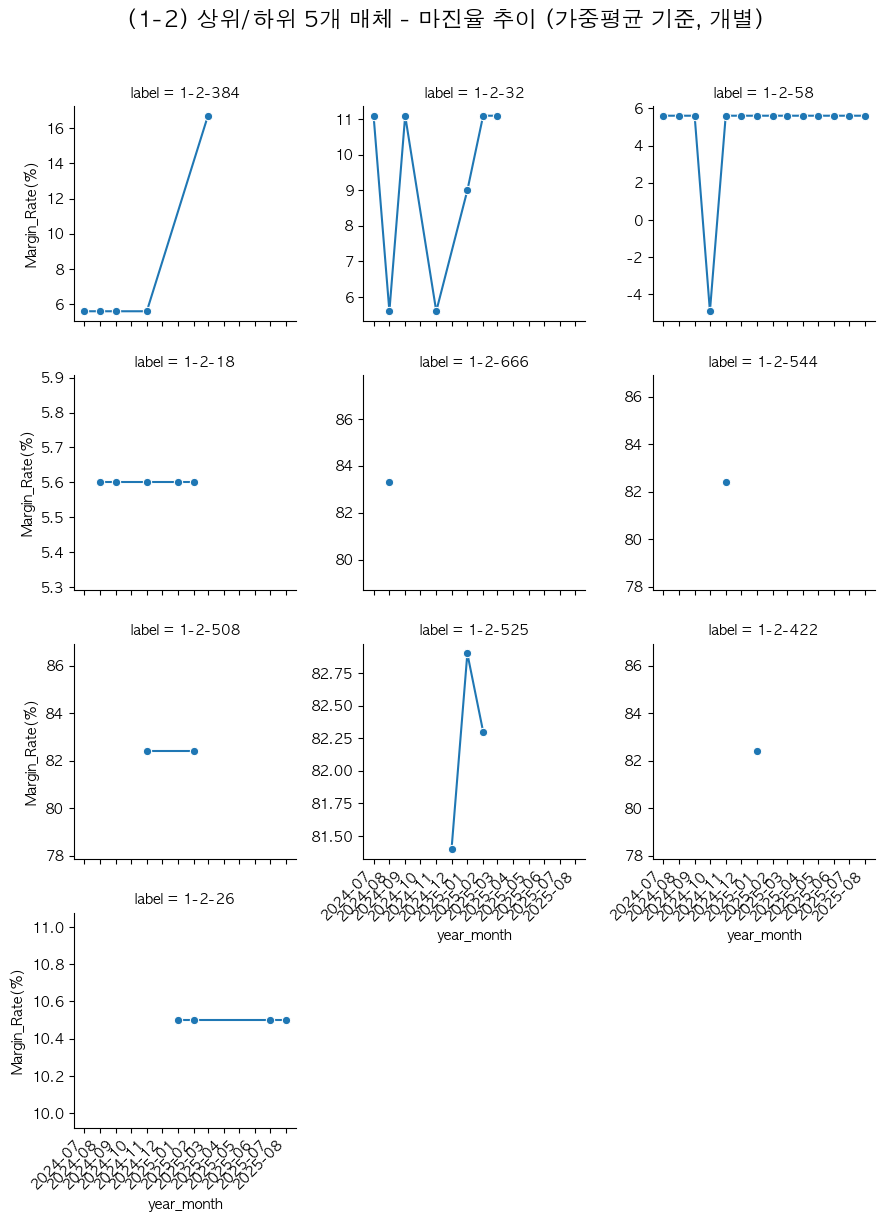

In [45]:
# 가중평균 사용

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 분석 대상 type-category
target_pair = (1, 2)

# 1. 해당 그룹 데이터 필터링
subset_pair = ad_hourly_df[
    (ad_hourly_df["ads_type"] == target_pair[0]) &
    (ad_hourly_df["ads_category"] == target_pair[1])
]

# 2. 월별 마진율 계산 (여기는 그대로 사용)
margin_pair = calc_margin_by_month(
    subset_pair,
    group_cols=["ads_type", "ads_category", "mda_idx"],
    earn_col="rpt_time_earn",
    acost_col="rpt_time_acost",
    date_col="rpt_time_date",
    as_percent=True,
    decimals=1,
    drop_zero_acost_groups=True
)

# 3. 날짜 정렬
margin_pair["year_month"] = pd.to_datetime(margin_pair["year_month"])
margin_pair = margin_pair.sort_values("year_month")

# 4. 매체별 전체기간 가중평균 마진율 계산
weighted_margin = (
    margin_pair.groupby(["ads_type", "ads_category", "mda_idx"])[["earn_sum", "acost_sum"]]
    .sum()
    .reset_index()
)

weighted_margin["Margin_Rate(%)"] = (
    (weighted_margin["acost_sum"] - weighted_margin["earn_sum"]) / weighted_margin["acost_sum"] * 100
).round(1)

# 상위/하위 5개
top5 = weighted_margin.nlargest(5, "Margin_Rate(%)")["mda_idx"].tolist()
bottom5 = weighted_margin.nsmallest(5, "Margin_Rate(%)")["mda_idx"].tolist()
selected_mda = top5 + bottom5

# 5. 시각화 준비
filtered = margin_pair[margin_pair["mda_idx"].isin(selected_mda)].copy()
filtered["label"] = filtered[["ads_type", "ads_category", "mda_idx"]]\
                        .astype(str).agg("-".join, axis=1)

# 6. 시각화 (한 그래프에 비교)
plt.figure(figsize=(10,6))
sns.lineplot(
    data=filtered,
    x="year_month", y="Margin_Rate(%)",
    hue="label", marker="o"
)

plt.title(f"({target_pair[0]}-{target_pair[1]}) 상위/하위 5개 매체 - 마진율 추이 (가중평균 기준)", fontsize=14)
plt.ylabel("Margin Rate (%)")
plt.xlabel("Year-Month")

# X축 YYYY-MM 보기 좋게
filtered["year_month_str"] = filtered["year_month"].dt.strftime("%Y-%m")
plt.gca().set_xticks(filtered["year_month"].unique())
plt.gca().set_xticklabels(filtered["year_month_str"].unique(), rotation=45, ha="right")

plt.legend(title="조합", loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0)
plt.tight_layout()
plt.show()

# 7. FacetGrid 개별 시계열
g = sns.FacetGrid(filtered, col="label", col_wrap=3, height=3, sharey=False)
g.map_dataframe(sns.lineplot, x="year_month", y="Margin_Rate(%)", marker="o")

# X축 라벨 보기 좋게
for ax in g.axes.flat:
    labels = filtered["year_month"].dt.strftime("%Y-%m").unique()
    ax.set_xticks(filtered["year_month"].unique())
    ax.set_xticklabels(labels, rotation=45, ha="right")

plt.subplots_adjust(top=0.9)
g.fig.suptitle(f"({target_pair[0]}-{target_pair[1]}) 상위/하위 5개 매체 - 마진율 추이 (가중평균 기준, 개별)", fontsize=16)
plt.show()


## 7-8월 하위 마진율

In [46]:
margin__bottom_78_df

,ads_type_nm,ads_category_nm,mda_idx,rpt_time_acost,rpt_time_earn,margin,margin_rate,margin_rate_pct
0,3,13,54.0,4658.0,4658.0,0.0,0.000000,0.0
1,3,13,389.0,460.0,450.0,10.0,0.021739,2.2
2,3,13,817.0,225.0,220.0,5.0,0.022222,2.2
3,3,13,1061.0,235.0,225.0,10.0,0.042553,4.3
4,1,2,58.0,26916840.0,25421460.0,1495380.0,0.055556,5.6
5,1,1,58.0,11631780.0,10985570.0,646210.0,0.055556,5.6
6,3,8,344.0,562950.0,531675.0,31275.0,0.055556,5.6
7,1,1,384.0,927000.0,875500.0,51500.0,0.055556,5.6
8,3,8,342.0,1329750.0,1255875.0,73875.0,0.055556,5.6
9,3,8,343.0,2905200.0,2743800.0,161400.0,0.055556,5.6


### 7-8월과 1년치에서 겹치는 조합 시계열 확인
#### 1-2-58, 3-13-389, 3-13-1061


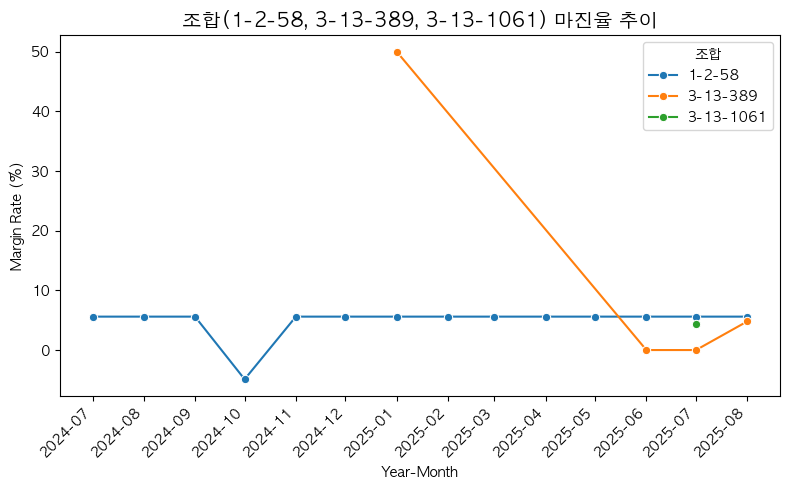

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 분석 대상
targets = [(1, 2, 58), (3, 13, 389), (3, 13, 1061)]

# 해당 조합 필터링
subset = ad_hourly_df[ad_hourly_df[["ads_type", "ads_category", "mda_idx"]]
                      .apply(tuple, axis=1).isin(targets)]

# 월별 마진율 계산
margin_ts = calc_margin_by_month(
    subset,
    group_cols=["ads_type", "ads_category", "mda_idx"],
    earn_col="rpt_time_earn",
    acost_col="rpt_time_acost",
    date_col="rpt_time_date",
    as_percent=True,
    decimals=1,
    drop_zero_acost_groups=True
)

# year_month 정렬 (날짜 순서 보장)
margin_ts["year_month"] = pd.to_datetime(margin_ts["year_month"])
margin_ts = margin_ts.sort_values("year_month")

# 라벨 생성
margin_ts["label"] = margin_ts[["ads_type", "ads_category", "mda_idx"]]\
                            .astype(str).agg("-".join, axis=1)

# 시각화
plt.figure(figsize=(8,5))
sns.lineplot(
    data=margin_ts,
    x="year_month", y="Margin_Rate(%)",
    hue="label", marker="o"
)

plt.title("조합(1-2-58, 3-13-389, 3-13-1061) 마진율 추이", fontsize=14)
plt.ylabel("Margin Rate (%)")
plt.xlabel("Year-Month")

# X축 YYYY-MM 보기 좋게
margin_ts["year_month_str"] = margin_ts["year_month"].dt.strftime("%Y-%m")
plt.gca().set_xticks(margin_ts["year_month"].unique())
plt.gca().set_xticklabels(margin_ts["year_month_str"].unique(), rotation=45, ha="right")

plt.legend(title="조합", loc="best")
plt.tight_layout()
plt.show()


### 7-8월과 1년치에서 안겹치는 조합
#### 3-13-54 , 3-13-817 , 1-1-58 , 3-8-344 , 1-1-384 , 3-8-342 , 3-8-343

### 안겹치는 조합 시계열 확인

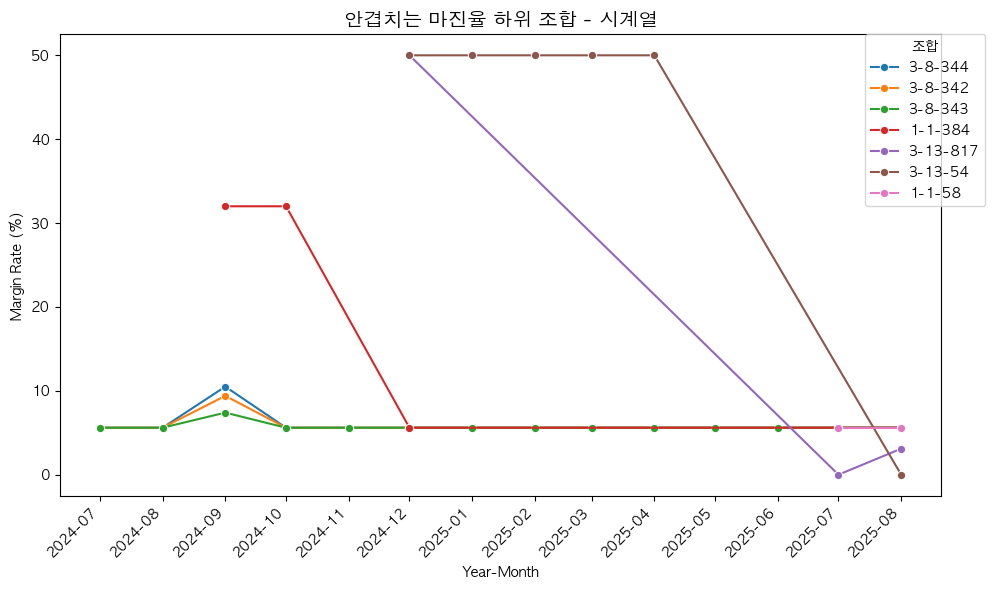

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 분석 대상
targets = [
    (3, 13, 54), (3, 13, 817), (1, 1, 58),
    (3, 8, 344), (1, 1, 384), (3, 8, 342), (3, 8, 343)
]

# 해당 조합 필터링
subset = ad_hourly_df[ad_hourly_df[["ads_type", "ads_category", "mda_idx"]]
                      .apply(tuple, axis=1).isin(targets)]

# 월별 마진율 계산
margin_ts = calc_margin_by_month(
    subset,
    group_cols=["ads_type", "ads_category", "mda_idx"],
    earn_col="rpt_time_earn",
    acost_col="rpt_time_acost",
    date_col="rpt_time_date",
    as_percent=True,
    decimals=1,
    drop_zero_acost_groups=True
)

# 날짜 정렬
margin_ts["year_month"] = pd.to_datetime(margin_ts["year_month"])
margin_ts = margin_ts.sort_values("year_month")

# 라벨 생성
margin_ts["label"] = margin_ts[["ads_type", "ads_category", "mda_idx"]]\
                                .astype(str).agg("-".join, axis=1)

# ---- (1) 전체를 한 그래프에 ----
plt.figure(figsize=(10,6))
sns.lineplot(
    data=margin_ts,
    x="year_month", y="Margin_Rate(%)",
    hue="label", marker="o"
)

plt.title("안겹치는 마진율 하위 조합 - 시계열", fontsize=14)
plt.ylabel("Margin Rate (%)")
plt.xlabel("Year-Month")

# X축 YYYY-MM 보기 좋게
margin_ts["year_month_str"] = margin_ts["year_month"].dt.strftime("%Y-%m")
plt.gca().set_xticks(margin_ts["year_month"].unique())
plt.gca().set_xticklabels(margin_ts["year_month_str"].unique(), rotation=45, ha="right")

plt.legend(title="조합", loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0)
plt.tight_layout()
plt.show()




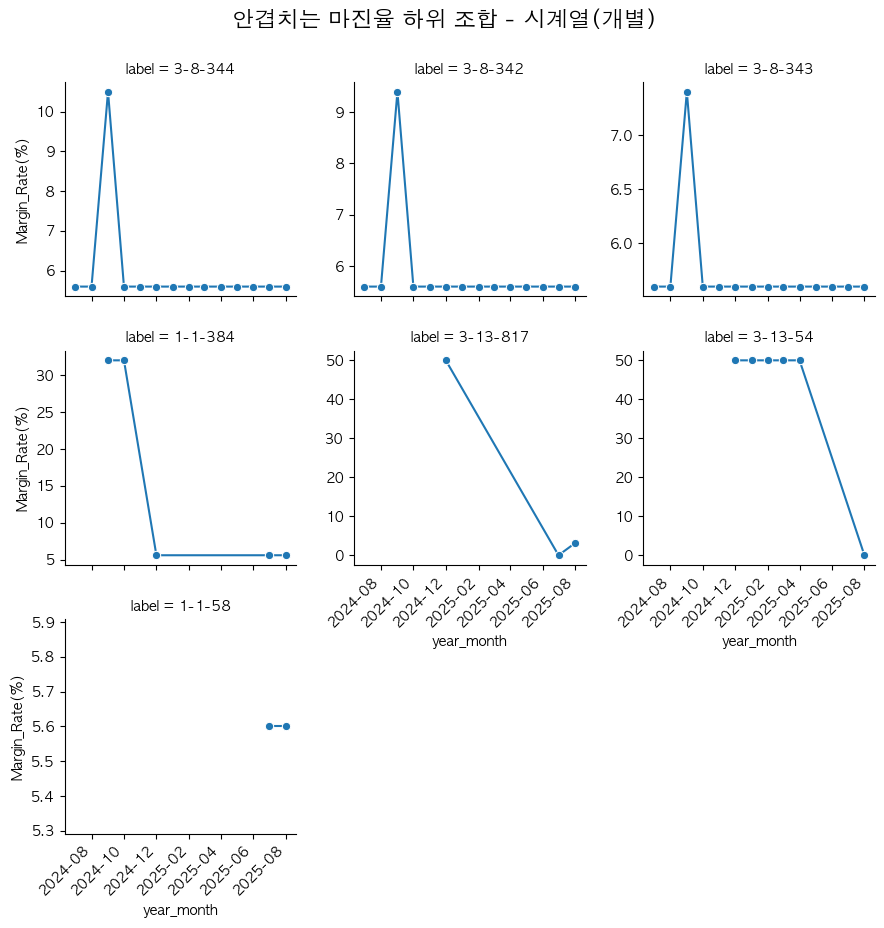

In [49]:
import matplotlib.dates as mdates

# ---- (2) 조합별 개별 그래프 ----
g = sns.FacetGrid(margin_ts, col="label", col_wrap=3, height=3, sharey=False)
g.map_dataframe(sns.lineplot, x="year_month", y="Margin_Rate(%)", marker="o")

# X축 라벨 깔끔하게 (월 단위 간격 설정)
for ax in g.axes.flat:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # 2개월 간격으로 표시 (원하면 3으로 바꿔도 됨)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("안겹치는 마진율 하위 조합 - 시계열(개별)", fontsize=16)
plt.show()


### 안겹치는 조합 다른매체와의 마진율 확인

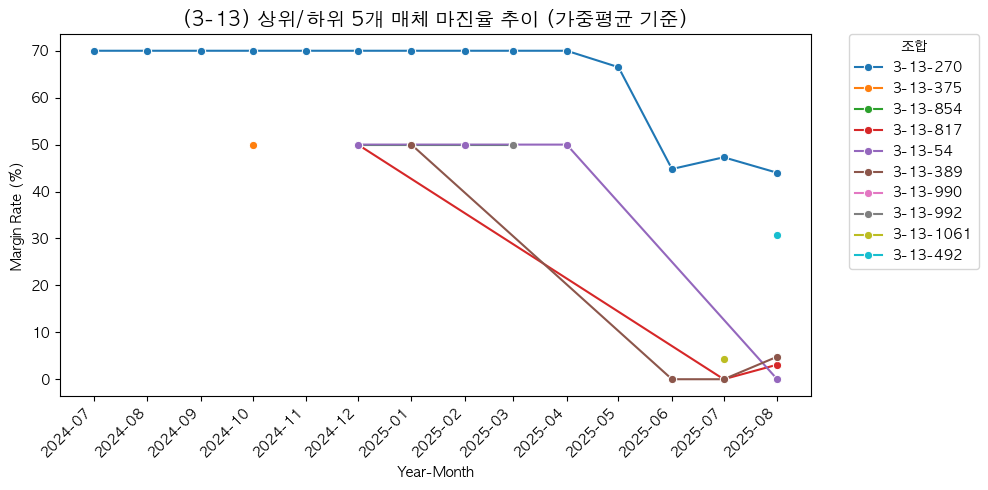

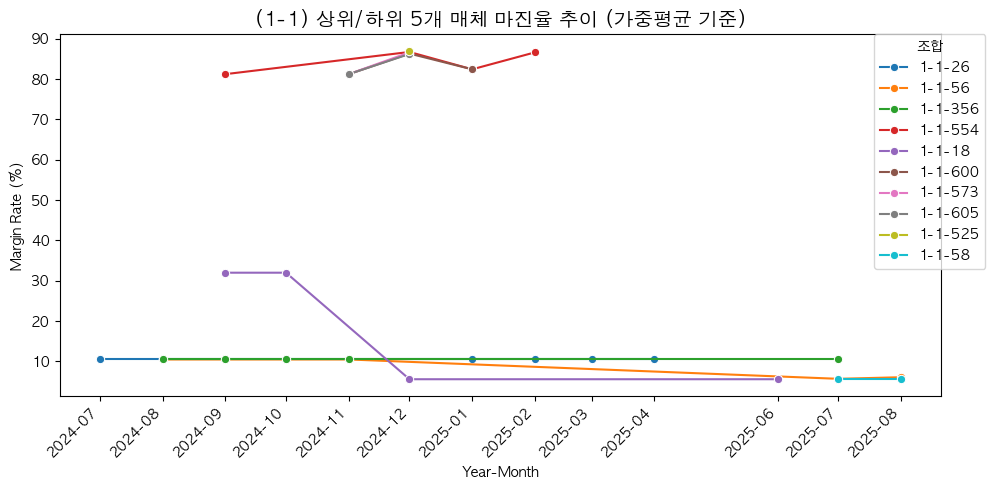

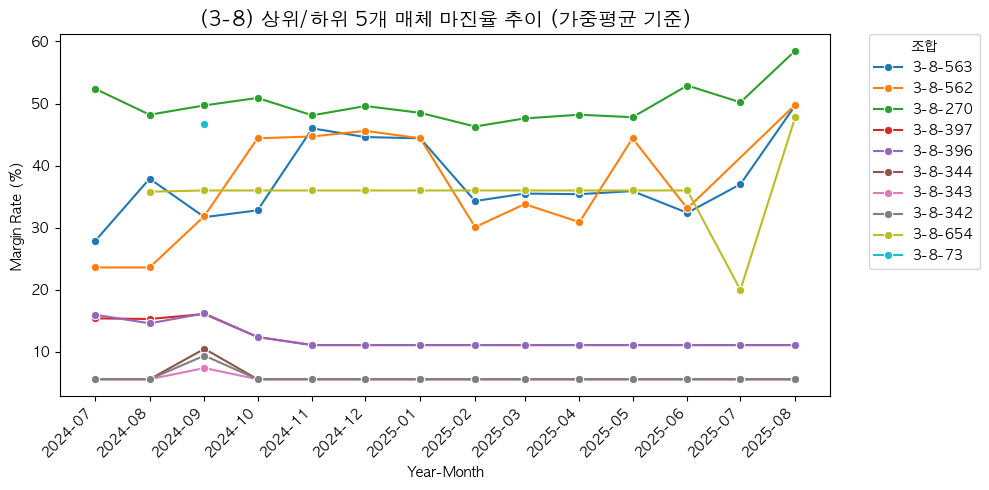

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 분석 대상 type-category 조합 (중복 제거)
target_pairs = [(3, 13), (1, 1), (3, 8)]

for pair in target_pairs:
    # 1. 해당 그룹 데이터 필터링
    subset_pair = ad_hourly_df[
        (ad_hourly_df["ads_type"] == pair[0]) &
        (ad_hourly_df["ads_category"] == pair[1])
    ]

    # 데이터 없으면 스킵
    if subset_pair.empty:
        print(f"({pair[0]}-{pair[1]}) 데이터 없음")
        continue

    # 2. 월별 마진율 계산
    margin_pair = calc_margin_by_month(
        subset_pair,
        group_cols=["ads_type", "ads_category", "mda_idx"],
        earn_col="rpt_time_earn",
        acost_col="rpt_time_acost",
        date_col="rpt_time_date",
        as_percent=True,
        decimals=1,
        drop_zero_acost_groups=True
    )

    # year_month datetime 변환 및 정렬
    margin_pair["year_month"] = pd.to_datetime(margin_pair["year_month"])
    margin_pair = margin_pair.sort_values("year_month")

    # 3. 매체별 전체기간 가중평균 마진율 계산
    weighted_margin = (
        margin_pair.groupby(["ads_type", "ads_category", "mda_idx"])[["earn_sum", "acost_sum"]]
        .sum()
        .reset_index()
    )
    weighted_margin["Margin_Rate(%)"] = (
        (weighted_margin["acost_sum"] - weighted_margin["earn_sum"]) / weighted_margin["acost_sum"] * 100
    ).round(1)

    # Top5 / Bottom5 선택
    top5 = weighted_margin.nlargest(5, "Margin_Rate(%)")["mda_idx"].tolist()
    bottom5 = weighted_margin.nsmallest(5, "Margin_Rate(%)")["mda_idx"].tolist()
    selected_mda = top5 + bottom5

    # 4. 시각화 데이터 준비
    filtered = margin_pair[margin_pair["mda_idx"].isin(selected_mda)].copy()
    filtered["label"] = filtered[["ads_type", "ads_category", "mda_idx"]]\
                            .astype(str).agg("-".join, axis=1)

    # 5. 시각화 (한 그래프에 비교)
    plt.figure(figsize=(10,5))
    sns.lineplot(
        data=filtered,
        x="year_month", y="Margin_Rate(%)",
        hue="label", marker="o"
    )

    plt.title(f"({pair[0]}-{pair[1]}) 상위/하위 5개 매체 마진율 추이 (가중평균 기준)", fontsize=14)
    plt.ylabel("Margin Rate (%)")
    plt.xlabel("Year-Month")

    # X축 YYYY-MM 보기 좋게
    filtered["year_month_str"] = filtered["year_month"].dt.strftime("%Y-%m")
    plt.gca().set_xticks(filtered["year_month"].unique())
    plt.gca().set_xticklabels(filtered["year_month_str"].unique(), rotation=45, ha="right")

    plt.legend(title="조합", loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0)
    plt.tight_layout()
    plt.show()
